### Imports

In [1]:
import pandas as pd
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import seaborn as sns
pv.set_jupyter_backend('trame')
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.draw import polygon
from radiomics import featureextractor
import SimpleITK as sitk
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
import contextlib
import os
import sys
import warnings
import logging

@contextlib.contextmanager
def silence_all_output():
    """Temporarily silence stdout, stderr, warnings, and radiomics logs."""
    radiomics_loggers = {
        name: logging.getLogger(name).level
        for name in logging.root.manager.loggerDict
        if name.startswith("radiomics")
    }

    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                for name in radiomics_loggers:
                    logging.getLogger(name).setLevel(logging.CRITICAL)

                try:
                    yield
                finally:
                    # restore logging levels
                    for name, level in radiomics_loggers.items():
                        logging.getLogger(name).setLevel(level)


## Data Dictionary


### Dataset: `lidc-idri-nodule-counts-6-23-2015.xlsx`


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | Pode repetir (paciente com vários TACs). |
| **Number of Nodules** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” ou “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC. | 0, 1, 2, ... | 0 = sem nódulos. |
| **Nodules ≥3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC (independentemente da forma como os outros radiologistas marcaram a lesão). | 0, 1, 2, ... | — |
| **Nodules <3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” de pelo menos um dos quatro radiologistas do LIDC (sem que nenhum radiologista tenha atribuído à lesão uma marcação de “nódulo ≥ 3 mm”). | 0, 1, 2, ... | — |
| **Unnamed: 4** | — | Coluna sem informação. | — | Removida por não conter dados relevantes. |
| **Unnamed: 5** | — | Coluna explicativa. | — | Removida por não conter dados relevantes. |




### Dataset: `tcia-diagnosis-data-2012-04-20.xls`


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | — |
| **Patient Diagnosis** | `int` | Diagnóstico do paciente. | 1 = Benigno, 2 = Maligno Primário | Valores 0 (Desconhecido) e 3 (Metastático) foram removidos do dataset. |
| **Patient Diagnosis Method** | `string` | Método de diagnóstico. | `"Histology"`, `"Clinical"` | — |
| **Primary tumor site for metastatic disease** | `string` | Local de origem do tumor metastático. | `"Lung"`, `"Breast"`, ... | Normalmente vazio; apenas preenchido para casos metastáticos (removidos do dataset). |
| **Nodule 1 Diagnosis** | `int` | Diagnóstico do nódulo 1. | -1 = Desconhecido, 1 = Benigno, 2 = Maligno Primário, 3 = Metastático | Valores NaN convertidos para -1. |
| **Nodule 1 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 1. | `"Histology"`, `"Clinical"` | — |
| **Nodule 2 Diagnosis** | `int` | Diagnóstico do nódulo 2. | -1, 1, 2, 3 | Valores NaN convertidos para -1. |
| **Nodule 2 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 2. | `"Histology"`, `"Clinical"` | — |
| **Nodule 3 Diagnosis** | `int` | Diagnóstico do nódulo 3. | -1, 1, 2, 3 | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 3 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 3. | `"Histology"`, `"Clinical"` | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis** | `int` | Diagnóstico do nódulo 4. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 4. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis** | `int` | Diagnóstico do nódulo 5. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 5. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |

### Número de nódulos por paciente.

In [3]:
nodules = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')

In [4]:
nodules.columns

Index(['TCIA Patent ID', 'Total Number of Nodules* ',
       'Number of Nodules >=3mm**', 'Number of Nodules <3mm***', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')

In [5]:
nodules.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


In [6]:
nodules.isna().sum()

TCIA Patent ID                  1
Total Number of Nodules*        0
Number of Nodules >=3mm**       0
Number of Nodules <3mm***       0
Unnamed: 4                   1019
Unnamed: 5                   1016
dtype: int64

Como as colunas 4 e 5 não parecem ter informação relevante, podemos apenas apagá-las sem problemas.

In [7]:
nodules = nodules.iloc[:, :-2]

#### Aproveitamos para renomear o nome das colunas

In [8]:
nodules.columns = ['Patient_ID', 'Number of Nodules', 'Nodules >=3mm', 
                         'Nodules <3mm']

Falta procurar o último NaN que existe.

In [9]:
nan_rows = nodules[nodules.isnull().any(axis=1)]
nan_rows.head()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1018,NaN,7371,2669,4702


Que facilmente descobrimos vir da última linha, que apenas serve para somar todas as quantidades.
Eliminamos então essa linha..

In [10]:
nodules = nodules.drop(nodules.index[-1])

... e confirmamos se foi corretamente eliminada.

In [11]:
nodules.tail()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1013,LIDC-IDRI-1008,7,6,1
1014,LIDC-IDRI-1009,2,1,1
1015,LIDC-IDRI-1010,10,1,9
1016,LIDC-IDRI-1011,4,4,0
1017,LIDC-IDRI-1012,1,1,0


#### Últimas verificações

In [12]:
nodules['Patient_ID'].nunique()

1010

Mas anteriormente vimos que existem 1018 entradas, logo, existem entradas repetidas. Vamos descobrir quais.

In [13]:
nodules[nodules['Patient_ID'].duplicated(keep=False)]

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
131,LIDC-IDRI-0132,14,6,8
132,LIDC-IDRI-0132,12,8,4
151,LIDC-IDRI-0151,3,1,2
152,LIDC-IDRI-0151,7,1,6
315,LIDC-IDRI-0315,13,7,6
316,LIDC-IDRI-0315,8,5,3
333,LIDC-IDRI-0332,6,5,1
334,LIDC-IDRI-0332,3,2,1
357,LIDC-IDRI-0355,4,1,3
358,LIDC-IDRI-0355,3,2,1


Descobrimos então que afinal não são entradas repetidas, mas sim que alguns pacientes fizeram vários TACs! Isto é confirmado ao ir-se ao dataset. Podemos manter todas estas entradas, mas temos de guardar cada um destes pacientes e tratar ambos os seus TACs como casos diferentes!

In [14]:
multiple_entries = nodules[nodules['Patient_ID'].duplicated(keep=False)]['Patient_ID'].unique().tolist()
multiple_entries = [s[10:] for s in multiple_entries] # Retirar o 'LIDC-IDRI-' do nome
multiple_entries

['0132', '0151', '0315', '0332', '0355', '0365', '0442', '0484']

### Diagnóstico dos pacientes

In [15]:
diagnosis = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')

Vamos limpar o nome das colunas

In [16]:
diagnosis.columns = ['Patient_ID', 'Patient Diagnosis', 'Patient Diagnosis Method', 
                         'Primary tumor site for metastatic disease',
                         'Nodule 1 Diagnosis', 'Nodule 1 Diagnosis Method', 
                         'Nodule 2 Diagnosis', 'Nodule 2 Diagnosis Method', 
                         'Nodule 3 Diagnosis', 'Nodule 3 Diagnosis Method',
                         'Nodule 4 Diagnosis', 'Nodule 4 Diagnosis Method',
                         'Nodule 5 Diagnosis', 'Nodule 5 Diagnosis Method']
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LIDC-IDRI-1004,2,3,LUL NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,LIDC-IDRI-1010,0,0,lymphoma,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notamos que existem várias colunas com valores a NaN, há necessidade?

In [17]:
diagnosis.isna().sum()

Patient_ID                                     0
Patient Diagnosis                              0
Patient Diagnosis Method                       0
Primary tumor site for metastatic disease      0
Nodule 1 Diagnosis                            20
Nodule 1 Diagnosis Method                     20
Nodule 2 Diagnosis                           137
Nodule 2 Diagnosis Method                    137
Nodule 3 Diagnosis                           156
Nodule 3 Diagnosis Method                    156
Nodule 4 Diagnosis                           157
Nodule 4 Diagnosis Method                    157
Nodule 5 Diagnosis                           157
Nodule 5 Diagnosis Method                    157
dtype: int64

Como o dataset tem 157 entradas, as últimas 4 colunas nunca possuem dados. Facilmente vemos que o único valor que existe na outra coluna é apenas erro de leitura.

In [18]:
diagnosis[~pd.isna(diagnosis['Nodule 3 Diagnosis'])]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
114,LIDC-IDRI-0285,3,3,melanoma,3.0,3.0,0.0,0.0,,,NaN,NaN,NaN,NaN


Portanto, podemos simplesmente apagar estas 3 colunas.

In [19]:
diagnosis = diagnosis.iloc[:, :-6]
diagnosis.head(3)

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN


In [20]:
diagnosis.dtypes

Patient_ID                                    object
Patient Diagnosis                              int64
Patient Diagnosis Method                       int64
Primary tumor site for metastatic disease     object
Nodule 1 Diagnosis                           float64
Nodule 1 Diagnosis Method                    float64
Nodule 2 Diagnosis                           float64
Nodule 2 Diagnosis Method                    float64
dtype: object

Os valores dos nódulos 1 e 2 deviam ser sempre inteiros, visto que são apenas classificações. Para convertermos uma coluna de floats em inteiros precisamos primeiro que não existam NaNs. Para isso, vamos primeiro converter todos os valores NaN em -1.

In [21]:
cols = diagnosis.columns[4:8]  # select the numeric columns explicitly
diagnosis[cols] = diagnosis[cols].apply(lambda x: x.fillna(-1).astype(int))
print(diagnosis.dtypes)
diagnosis.head(3)

Patient_ID                                   object
Patient Diagnosis                             int64
Patient Diagnosis Method                      int64
Primary tumor site for metastatic disease    object
Nodule 1 Diagnosis                            int64
Nodule 1 Diagnosis Method                     int64
Nodule 2 Diagnosis                            int64
Nodule 2 Diagnosis Method                     int64
dtype: object


,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3,4,-1,-1
1,LIDC-IDRI-0071,3,1,Head & Neck,1,1,-1,-1
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1


In [22]:
diagnosis[diagnosis['Nodule 1 Diagnosis'] == -1]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
120,LIDC-IDRI-0314,2,2,adenocarcinoma,-1,-1,-1,-1
121,LIDC-IDRI-0325,2,2,squamous cell carcinoma/non-small cell,-1,-1,-1,-1
126,LIDC-IDRI-0405,1,2,reactive mesothelial cells,-1,-1,-1,-1
127,LIDC-IDRI-0454,2,2,non-small cell carcinoma,-1,-1,-1,-1
130,LIDC-IDRI-0510,1,2,focal fibrosis,-1,-1,-1,-1
131,LIDC-IDRI-0522,2,2,Adenocarcinoma,-1,-1,-1,-1
132,LIDC-IDRI-0543,2,2,small cell carcinoma,-1,-1,-1,-1
134,LIDC-IDRI-0562,2,3,adenocarcinoma,-1,-1,-1,-1
136,LIDC-IDRI-0576,0,2,reactive mesothelial cells,-1,-1,-1,-1
139,LIDC-IDRI-0624,1,3,Histoplasmosis with necrotizing granulomas,-1,-1,-1,-1


Basicamente:  
Paciente é diagnosticado com cancro pulmonar, mas não há informação acerca dos nódulos. ChatGPT disse:

If your model predicts cancer at the nodule level:  
→ Exclude nodules with missing labels.  

If your model predicts cancer at the patient level:  
→ Keep these patients, but make sure your data aggregation handles missing nodules.

No ficheiro ```tcia-diagnosis-data-2012-04-20.xls``` temos 2 dados que nos são relevantes: **Diagnósitco do Paciente** e **Diagnóstico do Nódulo**
- Desconhecido
- Benigno
- Maligno (Cancro de Pulmão Primário)
- Maligno (Metastático)

Vamos ignorar pacientes cujo diagnóstico é desconhecido, pois estes não têm interesse nenhum ao nosso objetivo final, estaríam apenas a adicionar ruído que pode enganar o modelo.  
Também vamos ignorar cancros Malignos Metastáticos. Estes são cancros cujo local de origem é outra área do corpo, o nosso objetivo não é diferenciar cancro de pulmão primário de cancro metastático. Características visuais podem ser diferentes, confundindo o modelo.

In [23]:
diagnosis = diagnosis[(diagnosis['Patient Diagnosis'] != 0) & (diagnosis['Patient Diagnosis'] != 3)]
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1
4,LIDC-IDRI-0090,2,3,NSCLC,2,3,-1,-1
12,LIDC-IDRI-0138,2,2,Lung Cancer,2,2,-1,-1
14,LIDC-IDRI-0149,1,1,chondrosarcoma,1,1,-1,-1
17,LIDC-IDRI-0162,1,1,gallbladder,1,1,-1,-1
...,...,...,...,...,...,...,...,...
150,LIDC-IDRI-0939,2,3,RUL Small cell,2,3,-1,-1
151,LIDC-IDRI-0965,2,3,Adenocarcinoma,-1,-1,-1,-1
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2,3,-1,-1
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,-1,-1,-1,-1


Foram removidas 78 entradas (157 - 79).

In [24]:
diagnosis[diagnosis['Nodule 2 Diagnosis'] == 3]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
27,LIDC-IDRI-0174,2,3,nonsmall cell lung cancer,2,3,3,4
58,LIDC-IDRI-0214,2,3,non small cell lung,2,3,3,4
128,LIDC-IDRI-0470,2,2,nonsmall cell lung cancer,2,2,3,4


### Criação de um dataset com todas as anotações

In [25]:
# Obtém todos os scans disponíveis
def gen_dataset():
    scans = pl.query(pl.Scan).all()
    
    if not scans:
        print("No scans found, verify if the path is correct.")
        exit(1)
    
    with open('data.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # cabeçalho
        writer.writerow([
            'NoduloID', 'Annotation ID', 'Num Annotations',
            'Malignancy', 'Calcification', 'Internal Structure',
            'Spiculation', 'Margin', 'Subtlety',
            'Lobulation', 'Texture', 'Sphericity',
            'Volume',
            'Slice Thickness (mm)', 'Pixel Resolution'
        ])
        
        for scan in scans:
    
            nodulos = scan.cluster_annotations()
            num_nodulos = len(nodulos)
    
            slice_thickness = scan.slice_thickness
            pixel_spacing = scan.pixel_spacing
            
            # Verifica se existem nódulos
            if num_nodulos == 0:
                writer.writerow([
                    scan.patient_id[-4:], 0,
                    None, None, None, 
                    None, None, None, 
                    None, None, None,
                    None,
                    slice_thickness, pixel_spacing
                ])
            else:
                for idx, nodulo in enumerate(nodulos):
                    
                    num_an = len(nodulo)
    
                    nod_id = scan.patient_id[-4:] + f"-{idx+1}"
    
                    an_id = 1
                    for anotacao in nodulo:
    
                        writer.writerow([
                            nod_id, an_id, num_an, 
                            anotacao.malignancy, anotacao.calcification, anotacao.internalStructure,
                            anotacao.spiculation, anotacao.margin, anotacao.subtlety, 
                            anotacao.lobulation, anotacao.texture, anotacao.sphericity,
                            anotacao.volume,
                            slice_thickness, pixel_spacing
                        ])
                        an_id += 1
    
    print("Finished generating .csv file.")

#Convertido em função para não correr sempre que se dá run a tudo do notebook
#gen_dataset()

In [26]:
annotation_data = pd.read_csv('data.csv')
annotation_data = annotation_data.sort_values(by="NoduloID")
annotation_data = annotation_data.reset_index(drop=True)
annotation_data.to_csv('data.csv', index=False)
annotation_data.head()

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,1,4.0,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125
1,0001-1,2,4.0,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125
2,0001-1,3,4.0,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125
3,0001-1,4,4.0,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125
4,0002-1,1,2.0,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641


In [27]:
filtered = annotation_data[annotation_data['Num Annotations'] > 4]
filtered

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
490,0055-1,3,6.0,4.0,6.0,1.0,4.0,3.0,4.0,3.0,5.0,3.0,193.428040,2.5,0.703125
491,0055-1,1,6.0,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,205.169678,2.5,0.703125
492,0055-1,2,6.0,3.0,6.0,1.0,2.0,3.0,3.0,2.0,4.0,3.0,244.720459,2.5,0.703125
493,0055-1,6,6.0,2.0,6.0,1.0,1.0,5.0,3.0,3.0,5.0,3.0,1751.358032,2.5,0.703125
494,0055-1,4,6.0,4.0,6.0,1.0,2.0,3.0,4.0,3.0,4.0,4.0,292.304993,2.5,0.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,0942-1,6,7.0,3.0,6.0,1.0,3.0,5.0,5.0,4.0,5.0,5.0,2866.307831,1.0,0.742188
6568,0942-1,7,7.0,3.0,6.0,1.0,3.0,5.0,5.0,4.0,5.0,5.0,1169.438171,1.0,0.742188
6569,0942-1,2,7.0,4.0,6.0,1.0,3.0,1.0,5.0,2.0,3.0,5.0,3621.512604,1.0,0.742188
6570,0942-1,1,7.0,5.0,6.0,1.0,1.0,3.0,5.0,3.0,5.0,3.0,1413.736725,1.0,0.742188


In [28]:
wrong_nodule = filtered[filtered.columns[0]].unique()
print(f"Existem {len(wrong_nodule)} nodulos com anotações erradas")
wrong_nodule = [s[:4] for s in wrong_nodule.tolist()]
print(wrong_nodule)

Existem 14 nodulos com anotações erradas
['0055', '0092', '0137', '0204', '0252', '0332', '0340', '0366', '0404', '0608', '0815', '0863', '0865', '0942']


In [29]:
def print_all_ann(id: str, idx: list):
    %matplotlib inline
    
    # Select scan by patient ID
    pid = "LIDC-IDRI-" + id
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    
    if not scan:
        raise ValueError(f"No scan found for patient {pid}")
    
    anns = scan.annotations
    print(f"Found {len(anns)} annotations for patient {scan.patient_id}")
    
    for i, ann in enumerate(anns, 1):
        if (i in idx):
            ann.visualize_in_scan(False)

Found 8 annotations for patient LIDC-IDRI-0366


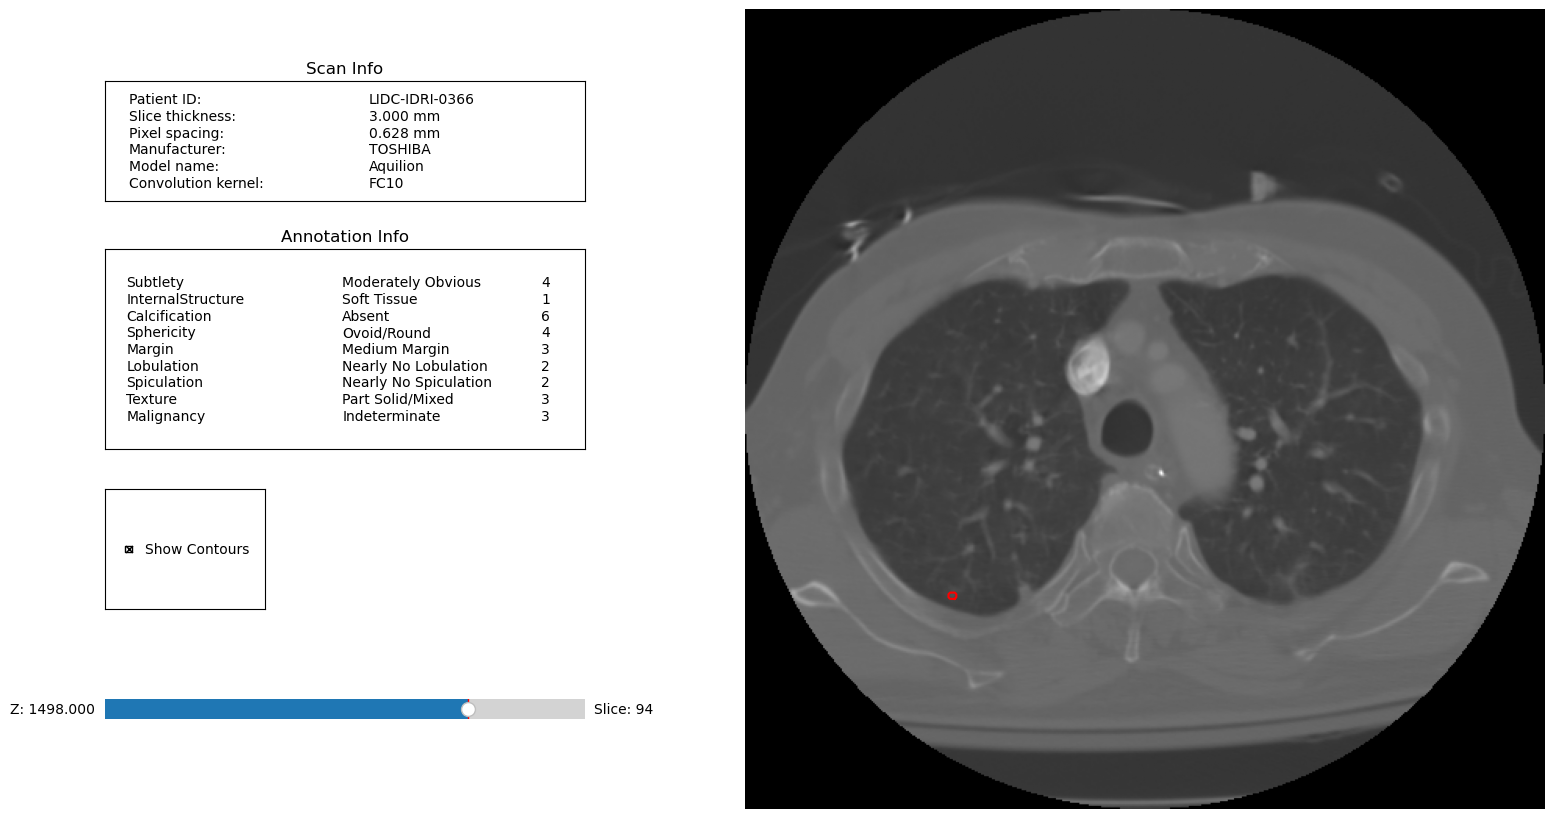

In [30]:
print_all_ann("0366", [2])

Found 8 annotations for patient LIDC-IDRI-0340


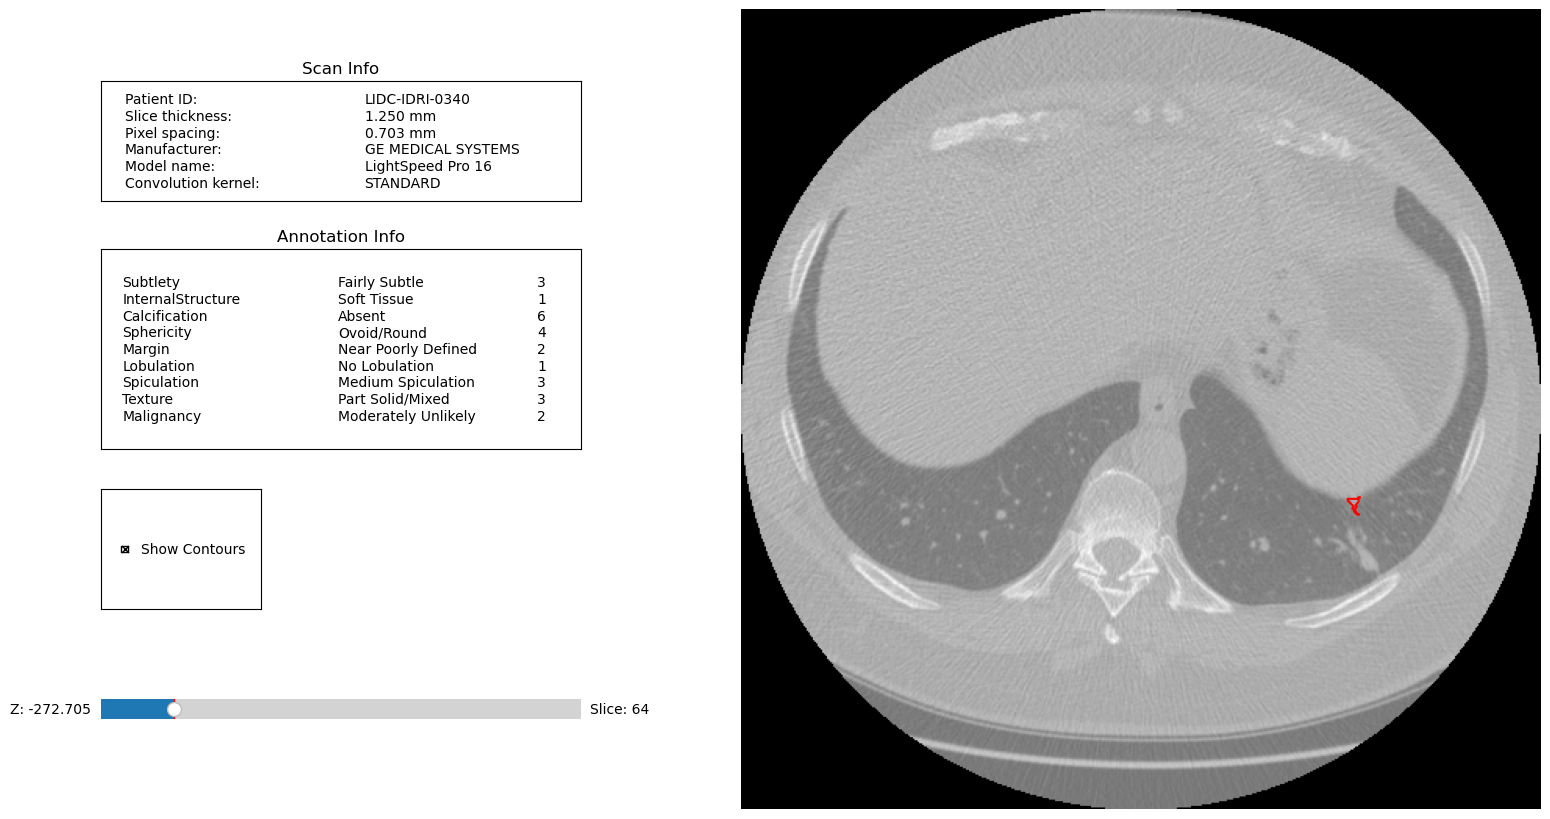

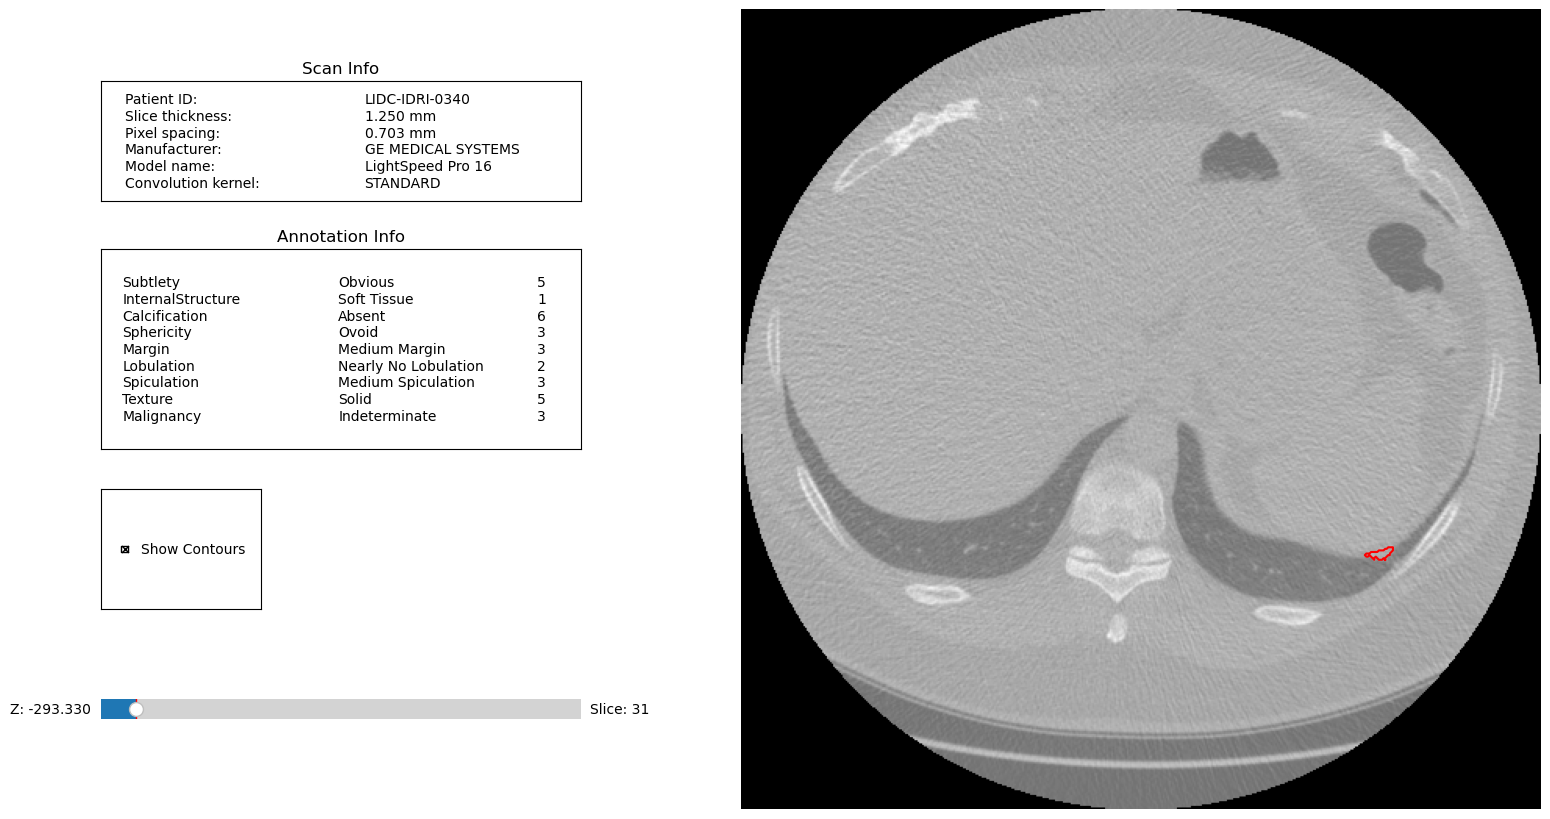

In [31]:
print_all_ann("0340", [7,8])

Como podemos ver, estas anotações estão erradas por diversos motivos, pelo que é boa ideia removê-las do dataset final.  
Sabemos que há 14 pacientes com anotações erradas, ou seja, anotações a mais.  
Será que existem pacientes sem anotações?

In [32]:
filtered = annotation_data[annotation_data['Num Annotations'] == 0]
no_nodule = filtered[filtered.columns[0]].unique()
print(f"Existem {len(no_nodule)} pacientes sem anotações")
print(no_nodule)

Existem 0 pacientes sem anotações
[]


**Confirmámos que os paciêntes sem nódulos estão todos incluídos na lista de paciêntes sem anotações.**

In [33]:
annotation_data.head(3)

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,1,4.0,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.5,0.703125
1,0001-1,2,4.0,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.5,0.703125
2,0001-1,3,4.0,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.5,0.703125


Foram convertidos corretamente!

### REMOÇÕES DO DATASET
Vamos remover todos os pacientes sem nodulos, estes nao nos servem para nada.  
Também vamos remover casos onde há mais de 4 anotações, como vimos anteriormente, estes acontecem por avaliação incorreta de nódulos, como vimos anteriormente. (Nódulo avaliado mal, nódulo identificado incorretamente, nódulo não identificado por completo, etc..).  
NÂO vamos remover pacientes com múltiplas entradas, pois estes vêm de diferentes TACs que um mesmo paciente fez e, portanto, podem ser tratados como casos válidos e distintos.

In [34]:
annotation_data = annotation_data[~annotation_data["NoduloID"].astype(str).str.startswith(tuple(f"{s}-" for s in wrong_nodule))]

Removemos 156 entradas de pacientes com nodulos mal lidos.

In [35]:
annotation_data = annotation_data[~annotation_data["NoduloID"].astype(str).str.startswith(tuple(f"{s}" for s in no_nodule))]

Removemos corretamente os 135 pacientes sem nodulos.
Em teoria, o dataset vai ter 6994 - 159 - 135 = 6700 entradas.

In [36]:
len(wrong_nodule)

14

Teremos também 1010 - 135 - 14 = 861 pacientes diferentes

In [37]:
annotation_data

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,1,4.0,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125
1,0001-1,2,4.0,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125
2,0001-1,3,4.0,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125
3,0001-1,4,4.0,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125
4,0002-1,1,2.0,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989,1011-4,1,1.0,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375
6990,1012-1,3,4.0,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656
6991,1012-1,2,4.0,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656
6992,1012-1,4,4.0,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656


In [38]:
df = annotation_data.copy()
df["base_id"] = annotation_data["NoduloID"].str.extract(r"^(\d+)-")

print(f"{df['base_id'].nunique()} pacientes diferentes.")

861 pacientes diferentes.


## Merge Datasets

- **NoduleCountsByPatient** (```lidc-idri-nodule-counts-6-23-2015.xlsx```): Vai ser usado.

- **PatientDiagnoses** (```tcia-diagnosis-data-2012-04-20.xls```) : Não vai ser utilizado. Para além de só ter apenas 157 pacientes, não contém nada relevante para classificar nódulos, visto que é impossível mapear os nódulos diagnosticados com os identificados no TAC.

- **DadosPylidc** (```data.csv``` que foi gerado): Este dataset é essencial, portanto vai ser utilizado.

btw incluimos volume no DadosPylidc porque **existem** relações entre volume de um nódulo e Malignancy/Internal Structure  
https://pmc.ncbi.nlm.nih.gov/articles/PMC3941244/  
TLDR: Inclusão de volume em prediction models aumenta classificação correta de nódulos pulmonares.



Como decidimos manter os pacientes que têm vários TACs, temos de ter bastante cuidado ao dar o merge dos datasets, pois queremos que os valores estejam corretos. Para tal, decidimos deixar esses 8 pacientes em branco.

In [39]:
import pandas as pd

# Clean 'id'
nodules_clean = nodules.copy()
nodules_clean["id_clean"] = nodules_clean["Patient_ID"].str.extract(r"LIDC-IDRI-(\d+)")

# Clean 'id'
annotation_data_clean = annotation_data.copy()
annotation_data_clean["id_clean"] = annotation_data_clean["NoduloID"].str.extract(r"(\d+)-").iloc[:, 0]

# Columns to be merged from 'nodules'
nodules_cols_to_merge = ["id_clean", "Number of Nodules", "Nodules >=3mm", "Nodules <3mm"]

# Dont change lines with these IDs
mask_keep_unchanged = annotation_data_clean["id_clean"].isin(multiple_entries)
merged_keep = annotation_data_clean[mask_keep_unchanged]

# Lines to be merged (ID is NOT in multiple_entries)
annotation_data_to_merge = annotation_data_clean[~mask_keep_unchanged]

merged_data = annotation_data_to_merge.merge(
    nodules_clean[nodules_cols_to_merge],
    on="id_clean",
    how="inner" 
)

merged = pd.concat([merged_data, merged_keep], ignore_index=True)

merged = merged.drop(columns=["id_clean"])

# Save the result
merged.to_csv("merged.csv", index=False)

merged

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,1,4.0,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,2,4.0,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,3,4.0,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,1,2.0,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,0484-1,4,4.0,1.0,6.0,4.0,3.0,3.0,5.0,5.0,4.0,5.0,3140.154253,3.00,0.705078,NaN,NaN,NaN
6699,0484-1,3,4.0,3.0,6.0,1.0,5.0,5.0,4.0,5.0,5.0,5.0,2977.591055,3.00,0.705078,NaN,NaN,NaN
6700,0484-1,2,4.0,3.0,6.0,1.0,2.0,4.0,5.0,3.0,5.0,4.0,1709.150688,3.00,0.705078,NaN,NaN,NaN
6701,0484-2,1,1.0,3.0,6.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,56.102966,3.00,0.710938,NaN,NaN,NaN


O número de linhas mantém-se, portanto podemos confirmar que foram juntos corretamente.

In [40]:
merged[merged.isnull().any(axis=1)]

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
6589,0132-1,1,3.0,1.0,6.0,1.0,1.0,5.0,3.0,1.0,5.0,4.0,129.818916,3.0,0.537109,NaN,NaN,NaN
6590,0132-1,2,3.0,3.0,6.0,1.0,2.0,3.0,4.0,3.0,5.0,4.0,115.538836,3.0,0.537109,NaN,NaN,NaN
6591,0132-1,3,3.0,3.0,6.0,1.0,2.0,3.0,2.0,2.0,4.0,4.0,194.295645,3.0,0.537109,NaN,NaN,NaN
6592,0132-1,1,1.0,4.0,6.0,1.0,1.0,4.0,4.0,1.0,4.0,4.0,169.125366,3.0,0.546875,NaN,NaN,NaN
6593,0132-2,2,2.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,5.0,3.0,126.789808,3.0,0.537109,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,0484-1,4,4.0,1.0,6.0,4.0,3.0,3.0,5.0,5.0,4.0,5.0,3140.154253,3.0,0.705078,NaN,NaN,NaN
6699,0484-1,3,4.0,3.0,6.0,1.0,5.0,5.0,4.0,5.0,5.0,5.0,2977.591055,3.0,0.705078,NaN,NaN,NaN
6700,0484-1,2,4.0,3.0,6.0,1.0,2.0,4.0,5.0,3.0,5.0,4.0,1709.150688,3.0,0.705078,NaN,NaN,NaN
6701,0484-2,1,1.0,3.0,6.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,56.102966,3.0,0.710938,NaN,NaN,NaN


Como não temos forma de saber qual valor no ```lidc-idri-nodule-counts-6-23-2015.xlsx``` corresponde a qual valor no ```merged.csv```, visto que apenas aparece um ```Pacient ID``` duplicado, com valores diferentes, temos de infelizmente remover estes elementos do dataset.

In [41]:
merged = merged.dropna()
merged

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,1,4.0,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,2,4.0,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,3,4.0,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,1,2.0,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,1011-4,1,1.0,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375,4.0,4.0,0.0
6585,1012-1,3,4.0,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656,1.0,1.0,0.0
6586,1012-1,2,4.0,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656,1.0,1.0,0.0
6587,1012-1,4,4.0,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656,1.0,1.0,0.0


In [42]:
df = merged.copy()
df["base_id"] = merged["NoduloID"].str.extract(r"^(\d+)-")

df["base_id"].nunique()

854

In [43]:
print(f"Is '{multiple_entries[3]}' in both lists: {multiple_entries[3] == wrong_nodule[5]}")

Is '0332' in both lists: True


Portanto, o numero de pacientes esta correto: 1010 - 135 (sem anotações) - 14 (anotações erradas) - 7 (repetidos) = 854.
Na verdade existem 8 repetidos, mas como existia um paciente repetido com anotações erradas, já tinha sido removido anteriormente.

In [44]:
merged[merged['Number of Nodules'] == 0]

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [45]:
merged[merged['Nodules >=3mm'] == 0]

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [46]:
merged[merged['Num Annotations'] > 4]

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [47]:
df = merged.copy()
df["base_id"] = df["NoduloID"].str.extract(r"^(\d+)-")
df["num"] = df["NoduloID"].str.extract(r"-(\d+)$").astype(int)

# Find max number per base_id
idx = df.groupby("base_id")["num"].idxmax()

# Keep only rows with the largest suffix for each base_id
df_max = df.loc[idx, ["NoduloID", "Nodules >=3mm", "num"]].reset_index(drop=True)

df_max[df_max['Nodules >=3mm'] != df_max['num']]

,NoduloID,Nodules >=3mm,num
56,0060-6,7.0,6
166,0179-11,12.0,11
422,0491-10,9.0,10
601,0707-6,7.0,6
622,0733-8,7.0,8
638,0753-1,2.0,1
739,0867-2,3.0,2


Após confirmar que estes valores estão mesmo errados, passamos a remover todos estes pacientes do dataset, visto que o número de nódulos não é consistente.

In [48]:
mismatched_nodules = df_max[df_max['Nodules >=3mm'] != df_max['num']]['NoduloID'].astype(str).str[:4].tolist()
mismatched_nodules

['0060', '0179', '0491', '0707', '0733', '0753', '0867']

In [49]:
for n in mismatched_nodules:
    merged = merged[~merged['NoduloID'].str.startswith(n)]
merged

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,1,4.0,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,2,4.0,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,3,4.0,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,1,2.0,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,1011-4,1,1.0,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375,4.0,4.0,0.0
6585,1012-1,3,4.0,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656,1.0,1.0,0.0
6586,1012-1,2,4.0,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656,1.0,1.0,0.0
6587,1012-1,4,4.0,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656,1.0,1.0,0.0


In [50]:
df = merged.copy()
df["base_id"] = merged["NoduloID"].str.extract(r"^(\d+)-")

df["base_id"].nunique()

847

In [51]:
merged.dtypes

NoduloID                 object
Annotation ID             int64
Num Annotations         float64
Malignancy              float64
Calcification           float64
Internal Structure      float64
Spiculation             float64
Margin                  float64
Subtlety                float64
Lobulation              float64
Texture                 float64
Sphericity              float64
Volume                  float64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules       float64
Nodules >=3mm           float64
Nodules <3mm            float64
dtype: object

Como sabemos que as caracteristicas do nodulo vao sempre ser de 0-5, é desnecessário estarem em floats.  
O número de cada tipo de nódulos também deve ser inteiro.

In [52]:
cols = merged.columns[2:12].union(merged.columns[15:18])
merged[cols] = merged[cols].apply(lambda x: x.fillna(-1).astype(int))
merged.dtypes

NoduloID                 object
Annotation ID             int64
Num Annotations           int64
Malignancy                int64
Calcification             int64
Internal Structure        int64
Spiculation               int64
Margin                    int64
Subtlety                  int64
Lobulation                int64
Texture                   int64
Sphericity                int64
Volume                  float64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules         int64
Nodules >=3mm             int64
Nodules <3mm              int64
dtype: object

In [53]:
merged.to_csv("merged.csv", encoding='utf-8', index=False)

In [54]:
merged['Malignancy'].value_counts()

Malignancy
3    2479
2    1528
1     957
4     893
5     634
Name: count, dtype: int64

Segundo a documentação do pylidc ```https://pylidc.github.io/annotation.html```, podemos ver que a pontuação atribuída a malignidade por radiologistas é caracterizada da seguinte forma:

1)  **‘Highly Unlikely’**  
2)  **‘Moderately Unlikely’**  
3)  **‘Indeterminate’**  
4)  **‘Moderately Suspicious’**  
5)  **‘Highly Suspicious’**  

Apesar de não garantirem diagnóstico definitivo, estas pontuações são úteis para avaliar a probabilidade.  
Podemos observar que é fácil criar uma identificação binária se considerarmos
- MalignancyAverage >= 3.5 -> 0
- MalignancyAverage <= 3.5 -> 1
- 2.5 < MalignancyAverage < 3.5 -> Deleted

Podem existir casos onde 3 radiologistas classificaram o nodulo como ```Highly Suspicious``` mas, como o 4º radiologista achou que era ```Indeterminate```, esse nodulo é completamente apagado. Casos onde a classificação é mesmo ambígua são apagados, mas desta forma perdemos menos informação.  
- Esta forma suaviza variância entre radiologistas.  
- Descarta nodulos verdadeiramente ambíguos.  
- Respeita a escala (aceita que 4 é "mais maligno" que 3).   
-> Tal forma de classificação vai de encontro com o nosso objetivo: decidir se um nódulo **é** ou **não** maligno.

Quanto às outras classificações, através da documentação do pylidc concluímos que todas elas estão classificadas de 1-5, sendo esta uma escala **ordenada e não ambígua**. Não faz sentido fazer mapeamento para outra escala, pois estaríamos apenas a perder informação. A única exceção é InternalStructure, mas nesse caso diferentes valores representam diferentes estruturas, sendo crucial mantê-la sem mudanças.


In [55]:
df = pd.read_csv('merged.csv')

# Calculate average malignancy for each NoduleID
malignancy_avg = df.groupby('NoduloID')['Malignancy'].mean()

def classify_malignancy(avg):
    if avg < 2.5:
        return 0
    elif avg > 3.5:
        return 1
    else:  # 2.5 <= avg <= 3.5
        return None  # Mark for deletion

# Apply classification to get the mapping
nodule_classification = malignancy_avg.apply(classify_malignancy)

# Filter out nodules that should be deleted (None values)
nodules_to_keep = nodule_classification[nodule_classification.notna()].index

# Filter the original dataframe to keep only valid nodules
df_filtered = df[df['NoduloID'].isin(nodules_to_keep)].copy()

# Update the Malignancy values based on the classification
df_filtered['Malignancy'] = df_filtered['NoduloID'].map(nodule_classification)

# Convert to boolean
df_filtered['Malignancy'] = df_filtered['Malignancy'].astype(bool)

# Display results
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"\nNodules removed (avg between 2.5 and 3.5): {len(df) - len(df_filtered)}")
print(f"\nUnique nodules before: {df['NoduloID'].nunique()}")
print(f"Unique nodules after: {df_filtered['NoduloID'].nunique()}")

# Show distribution of new Malignancy values
print("\nNew Malignancy distribution:")
print(df_filtered['Malignancy'].value_counts().sort_index())

Original dataset size: 6491
Filtered dataset size: 3009

Nodules removed (avg between 2.5 and 3.5): 3482

Unique nodules before: 2519
Unique nodules after: 1212

New Malignancy distribution:
Malignancy
False    1854
True     1155
Name: count, dtype: int64


In [56]:
df_filtered.dtypes

NoduloID                 object
Annotation ID             int64
Num Annotations           int64
Malignancy                 bool
Calcification             int64
Internal Structure        int64
Spiculation               int64
Margin                    int64
Subtlety                  int64
Lobulation                int64
Texture                   int64
Sphericity                int64
Volume                  float64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules         int64
Nodules >=3mm             int64
Nodules <3mm              int64
dtype: object

In [57]:
df_filtered.nunique()

NoduloID                1212
Annotation ID              4
Num Annotations            4
Malignancy                 2
Calcification              6
Internal Structure         3
Spiculation                5
Margin                     5
Subtlety                   5
Lobulation                 5
Texture                    5
Sphericity                 5
Volume                  2934
Slice Thickness (mm)      11
Pixel Resolution         188
Number of Nodules         41
Nodules >=3mm             18
Nodules <3mm              35
dtype: int64

Existe um problema com esta solução:  
Casos onde só há 2 anotações, onde uma delas é 3 e a outra 2/4, são eliminadas corretamente, pois a média fica a 2,5 ou 3,5.  
O problema está em casos onde temos [1,3] ou [3,5]. Estes representam ambiguidade máxima e **devem** ser apagados.  
Aproveitamos e verificamos se existem casos onde existe discordância: um radiologista acha que é maligno e outro benigno.  
Vamos verificar se existe algum desses casos.

In [58]:
df = pd.read_csv('merged.csv')

# Calculate average malignancy for each NoduleID
malignancy_stats = df.groupby('NoduloID').agg({
    'Malignancy': ['mean', 'min', 'max', 'count'],
    'Num Annotations': 'first'
}).reset_index()

malignancy_stats.columns = ['NoduloID', 'Avg', 'Min', 'Max', 'Count', 'NumAnnotations']

# Case 1: Average > 3.5 but has annotations with big disagreement
ambiguous_high = malignancy_stats[
    (malignancy_stats['Avg'] > 3.5) & 
    (malignancy_stats['NumAnnotations'] == 2) &
    (((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 5)) |
     ((malignancy_stats['Min'] == 2) & (malignancy_stats['Max'] == 5)) |
     ((malignancy_stats['Min'] == 3) & (malignancy_stats['Max'] == 5)))
]

# Case 2: Average < 2.5 but has annotations with big disagreement  
ambiguous_low = malignancy_stats[
    (malignancy_stats['Avg'] < 2.5) & 
    (malignancy_stats['NumAnnotations'] == 2) &
    (((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 5)) |
     ((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 4)) |
     ((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 3)))
]

# * Par [2,4] já foi apagado antes, porque a sua média é 3.

# Combine both cases
ambiguous_all = pd.concat([ambiguous_high, ambiguous_low]).drop_duplicates()

print(f"\nTotal unique nodules: {malignancy_stats['NoduloID'].nunique()}")
print(f"Nodules with 2 annotations: {len(malignancy_stats[malignancy_stats['NumAnnotations'] == 2])}")

print(f"\n--- HIGH AVERAGE BUT AMBIGUOUS (Avg > 3.5) ---")
print(f"Count: {len(ambiguous_high)}")
if len(ambiguous_high) > 0:
    print("\nExamples:")
    print(ambiguous_high[['NoduloID', 'Avg', 'Min', 'Max']].head(3))

print(f"\n--- LOW AVERAGE BUT AMBIGUOUS (Avg < 2.5) ---")
print(f"Count: {len(ambiguous_low)}")
if len(ambiguous_low) > 0:
    print("\nExamples:")
    print(ambiguous_low[['NoduloID', 'Avg', 'Min', 'Max']].head(3))


Total unique nodules: 2519
Nodules with 2 annotations: 462

--- HIGH AVERAGE BUT AMBIGUOUS (Avg > 3.5) ---
Count: 6

Examples:
     NoduloID  Avg  Min  Max
678    0266-1  4.0    3    5
1105   0454-2  4.0    3    5
1115   0457-2  4.0    3    5

--- LOW AVERAGE BUT AMBIGUOUS (Avg < 2.5) ---
Count: 42

Examples:
    NoduloID  Avg  Min  Max
275   0101-1  2.0    1    3
382   0136-3  2.0    1    3
383   0136-4  2.0    1    3


Verificámos que curiosamente os únicos casos que existiam eram [1,3] e [3,5]. Não houve **nenhuma** vez onde 2 radiologistas tenham discordaram muito.

In [59]:
ambiguous = ambiguous_low['NoduloID'].tolist() + ambiguous_high['NoduloID'].tolist()
print(ambiguous)

['0101-1', '0136-3', '0136-4', '0136-8', '0150-1', '0176-3', '0178-1', '0198-1', '0291-1', '0317-1', '0323-2', '0334-6', '0360-2', '0435-2', '0435-5', '0437-2', '0439-1', '0469-5', '0492-3', '0492-4', '0499-2', '0571-2', '0583-4', '0620-3', '0624-3', '0637-11', '0651-4', '0652-1', '0773-1', '0786-1', '0787-3', '0792-3', '0792-4', '0806-10', '0819-1', '0870-1', '0870-5', '0898-1', '0899-2', '0921-2', '0961-9', '0982-2', '0266-1', '0454-2', '0457-2', '0657-1', '0663-1', '0743-1']


In [60]:
# Remover todos os nodulos ambiguos
df_filtered = df_filtered[~df_filtered['NoduloID'].isin(ambiguous)].copy()
df_filtered.to_csv("annotations.csv", encoding='utf-8', index=False)
df_filtered

,NoduloID,Annotation ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,1,4,True,6,1,4,3,5,3,5,3,7869.369507,2.50,0.703125,4,1,3
1,0001-1,2,4,True,6,1,5,4,5,5,5,4,6146.438599,2.50,0.703125,4,1,3
2,0001-1,3,4,True,6,1,3,2,5,3,5,3,6594.474792,2.50,0.703125,4,1,3
3,0001-1,4,4,True,6,1,5,4,5,1,4,5,7348.411560,2.50,0.703125,4,1,3
4,0002-1,1,2,True,6,1,1,1,2,1,1,5,6576.900681,1.25,0.681641,12,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6486,1011-4,1,1,False,6,1,1,2,1,1,1,4,92.315674,2.50,0.859375,4,4,0
6487,1012-1,3,4,False,6,1,1,5,4,1,5,4,258.504689,2.50,0.722656,1,1,0
6488,1012-1,2,4,False,6,1,2,4,4,2,3,4,125.857838,2.50,0.722656,1,1,0
6489,1012-1,4,4,False,6,1,1,3,4,1,5,4,167.636374,2.50,0.722656,1,1,0


In [61]:
df_filtered['NoduloID'].str.split('-').str[0].nunique()

599

Resultado final é ```annotations.csv``` com ```2913 nódulos``` e ```617 pacientes``` diferentes.

### Pré-Processamento de Imagens

Agora que temos os pacientes e nódulos que devem ser utilizados neste projeto, devemos preparar os dados das imagens desses pacientes.

**Hounsfield Units (HU)**  
descrever HU  
Mantemos entre [-1000, 400] porque em HU -1000>= é ar e 300<= é osso

In [62]:
def to_hu(image):
    # In LIDC-IDRI these values are always maintained
    image = image.astype(np.int16)
    
    intercept = -1024
    slope = 1

    hu_image = image * slope + intercept
    hu_image = np.clip(hu_image, -1000, 400) 
    return hu_image

**Normalização**

In [63]:
def norm(hu_image):
    # [0,1]
    normalized_image = (hu_image - np.min(hu_image)) / (np.max(hu_image) - np.min(hu_image))
    return normalized_image

**Segmentação 2D**  
Divide a imagem as partes/regiões significativas para identificar nódulos

In [64]:
def seg2d(scan, annotation):
    volume = scan.to_volume()

    # Get the centroid (i, j, k)
    i, j, k = annotation.centroid
    slice_idx = int(k) 

    # Initialize binary mask for this slice
    mask = np.zeros(volume[:, :, slice_idx].shape, dtype=np.uint8)

    # Fill in all contours for this slice
    for contour in annotation.contours:
        if contour.image_k_position == slice_idx:
            # Convert contour coordinates to matrix form
            ij = contour.to_matrix(include_k=False)
            rr, cc = polygon(ij[:, 0], ij[:, 1], mask.shape)
            mask[rr, cc] = 1

    image_slice = volume[:, :, slice_idx]

    return image_slice, mask

**Segmentação 3D**

In [65]:
def seg3d(scan, annotation):
    volume = scan.to_volume()
    mask = np.zeros_like(volume, dtype=np.uint8)

    for contour in annotation.contours:
        z_index = int(contour.image_k_position)
        coords = contour.to_matrix(include_k=False)
        rr, cc = polygon(coords[:, 0], coords[:, 1], mask[:, :, z_index].shape)
        mask[rr, cc, z_index] = 1

    return volume, mask

### Teste das funções

In [66]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0132').first()
annotation = scan.annotations[0]
image = scan.load_all_dicom_images()[0]

Loading dicom files ... This may take a moment.


**Hounsfield Units (HU)**

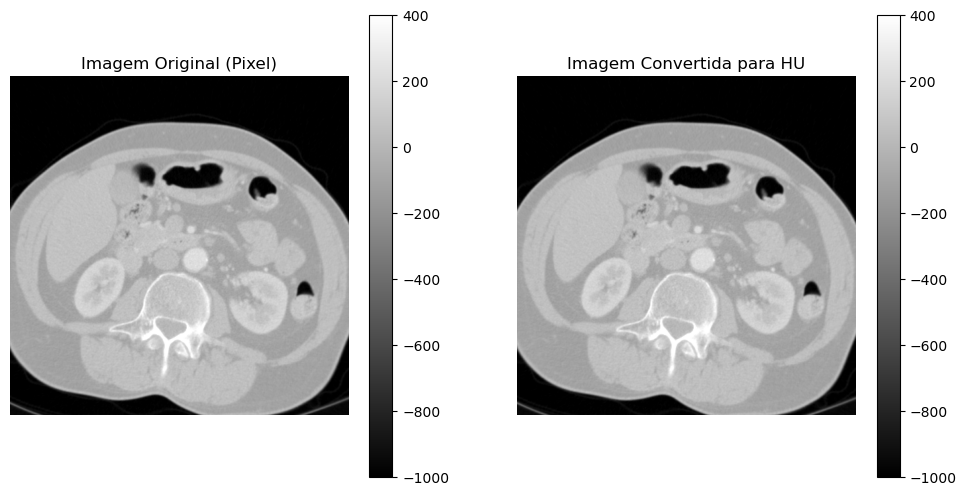

In [67]:
pixel_image = image.pixel_array

# Testar a função de conversão para HU
hu_image = to_hu(image.pixel_array)

# Visualizar as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagem original (pixels)
axes[0].imshow(pixel_image, cmap='gray')
axes[0].set_title('Imagem Original (Pixel)')

# Imagem convertida para HU
axes[1].imshow(hu_image, cmap='gray')
axes[1].set_title('Imagem Convertida para HU')

# Mostrar as barras de cor
for ax in axes:
    ax.axis('off')
    plt.colorbar(ax.imshow(hu_image, cmap='gray'), ax=ax)

plt.show()

Como é possível observar, não existe mudança visual entre as imagens, o que é bom, pois não é esse o propósito das HU.  
Se virmos o novo array da imagem, podemos notar que ele agora representa diferentes densidades e, consequentemente, diferentes materiais.

In [68]:
print(pixel_image)

[[29 29 25 ...  9 18 27]
 [34 36 31 ... 18 28 23]
 [34 40 33 ... 22 24 23]
 ...
 [87 78 73 ... 66 55 52]
 [86 70 71 ... 80 63 63]
 [77 65 73 ... 84 73 73]]


In [69]:
print(hu_image)

[[ -995  -995  -999 ... -1000 -1000  -997]
 [ -990  -988  -993 ... -1000  -996 -1000]
 [ -990  -984  -991 ... -1000 -1000 -1000]
 ...
 [ -937  -946  -951 ...  -958  -969  -972]
 [ -938  -954  -953 ...  -944  -961  -961]
 [ -947  -959  -951 ...  -940  -951  -951]]


**Normalização**

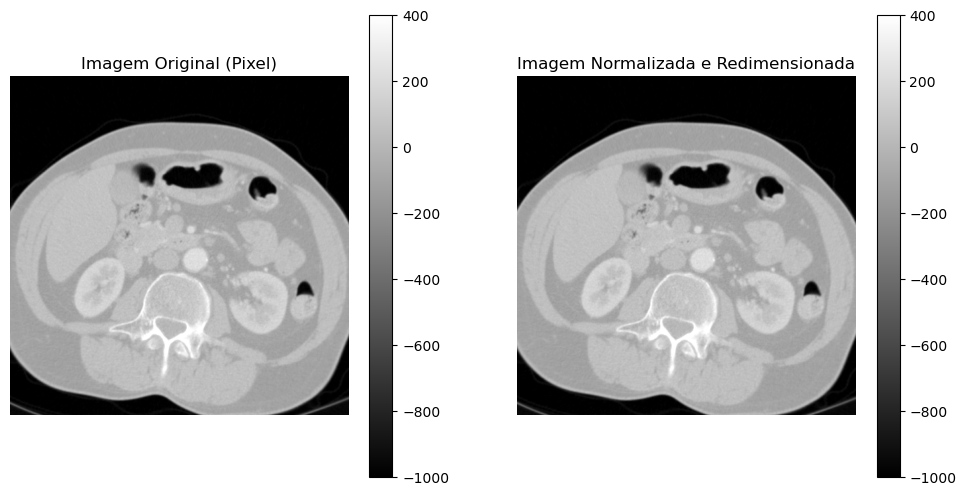

In [70]:
normalized_image = norm(hu_image)

# Visualizar as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagem original (pixels)
axes[0].imshow(pixel_image, cmap='gray')
axes[0].set_title('Imagem Original (Pixel)')

# Imagem convertida para HU
axes[1].imshow(normalized_image, cmap='gray')
axes[1].set_title('Imagem Normalizada e Redimensionada')

# Mostrar as barras de cor
for ax in axes:
    ax.axis('off')
    plt.colorbar(ax.imshow(hu_image, cmap='gray'), ax=ax)

plt.show()

O mesmo acontece com a Normalização, onde a diferença está na normalização destes valores.

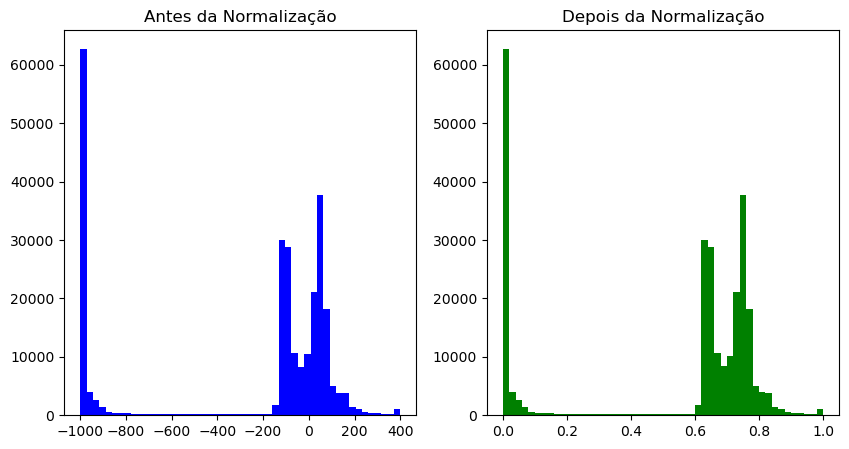

In [71]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(hu_image.flatten(), bins=50, color='blue')
plt.title('Antes da Normalização')

plt.subplot(1, 2, 2)
plt.hist(normalized_image.flatten(), bins=50, color='green')
plt.title('Depois da Normalização')

plt.show()

Loading dicom files ... This may take a moment.


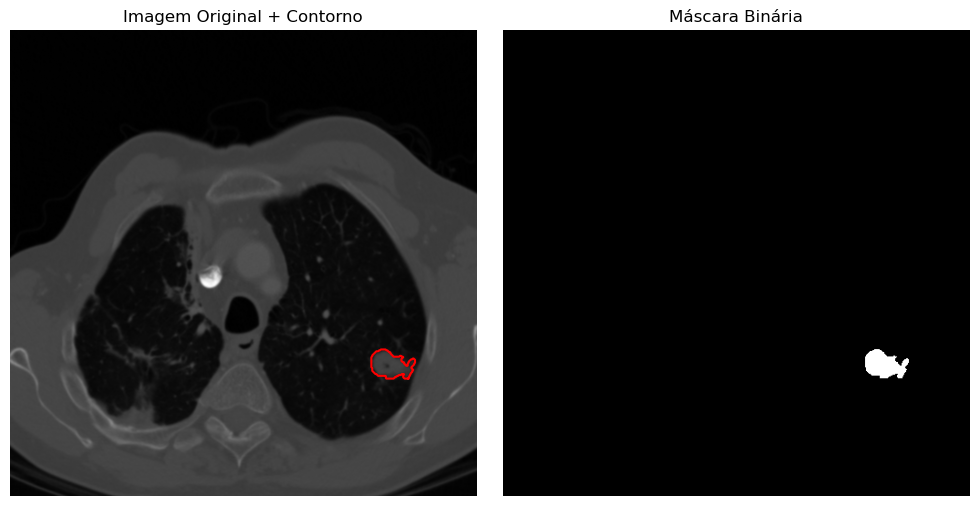

In [72]:
image, mask = seg2d(scan, annotation)

contours = measure.find_contours(mask, level=0.5)

# Plot for 2 images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left
axes[0].imshow(image, cmap='gray')
for contour in contours:
    axes[0].plot(contour[:, 1], contour[:, 0], color='red', linewidth=1.5)
axes[0].set_title('Imagem Original + Contorno')
axes[0].axis('off')

# Right
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Máscara Binária')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Loading dicom files ... This may take a moment.


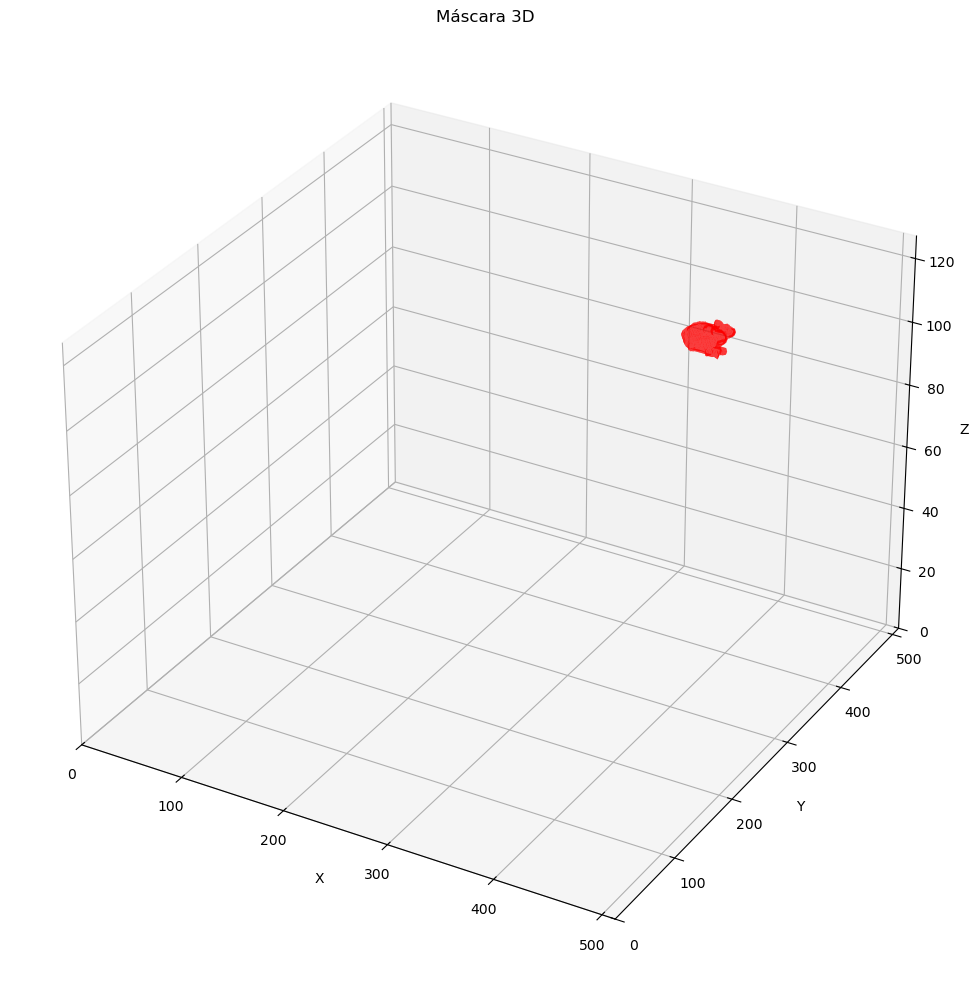

In [73]:
volume,mask = seg3d(scan, annotation)
verts, faces, _, _ = measure.marching_cubes(mask, level=0)

# --- Prepare mesh for Matplotlib ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a collection of triangles
mesh = Poly3DCollection(verts[faces], alpha=0.6)
mesh.set_facecolor('red')

# Add to the axes
ax.add_collection3d(mesh)

# Auto scale to the mesh size
ax.set_xlim(0, mask.shape[0])
ax.set_ylim(0, mask.shape[1])
ax.set_zlim(0, mask.shape[2])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Máscara 3D")

plt.tight_layout()
plt.show()

### Pacientes e Nódulos a Analizar

In [74]:
df = pd.read_csv('annotations.csv')
# Nodule/Annotation List
na_list = []

for nodule_id in df['NoduloID'].unique():
    # Get the subset of rows corresponding to this nodule
    subset = df[df['NoduloID'] == nodule_id]
    
    # Loop over each annotation for this nodule
    for annot_idx, row in enumerate(subset.itertuples(), start=1):
        na_list.append([nodule_id, annot_idx])

#### Extração de Features 2D

Estamos interessados nas ```First-Order```, ```Texture``` e ```Shape``` features.

In [75]:
extractor_2d = featureextractor.RadiomicsFeatureExtractor() 

extractor_2d.disableAllFeatures()

extractor_2d.enableFeatureClassByName('firstorder')   
extractor_2d.enableFeatureClassByName('glcm')         
extractor_2d.enableFeatureClassByName('glrlm')        
extractor_2d.enableFeatureClassByName('glszm')        
extractor_2d.enableFeatureClassByName('gldm')         
extractor_2d.enableFeatureClassByName('ngtdm')        
extractor_2d.enableFeatureClassByName('shape2D')

In [76]:
def extract(nodule_annot_list, extractor, verbose=False):
    feature_list = []
    for nodule_id_str, annotation_id in nodule_annot_list:
        patient_id = "LIDC-IDRI-" + nodule_id_str[:4]
        nodule_id = int(nodule_id_str[5:])
        if verbose:
            print(f"Processing Patient {patient_id}, Nodule {nodule_id}, Annotation {annotation_id}")
        
        # Get scans
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()
        if not scans:
            warnings.warn(f"No scans found for patient {patient_id}")
            continue
        
        for scan in scans:
            # Get all annotations (each annotation is from one radiologist)
            all_annotations = scan.annotations
            
            # Group annotations by nodule (cluster annotations that refer to the same nodule)
            nodules = scan.cluster_annotations()
            
            if nodule_id > len(nodules):
                warnings.warn(f"Nodule {nodule_id} not found for {patient_id}")
                continue
            
            # Get the specific nodule cluster (list of annotations for this nodule)
            nodule_annotations = nodules[nodule_id - 1]
            
            if annotation_id > len(nodule_annotations):
                warnings.warn(f"Annotation {annotation_id} not found for {nodule_id_str} (only {len(nodule_annotations)} annotations available)")
                continue
            
            # Get the SPECIFIC annotation (1-indexed)
            specific_annotation = nodule_annotations[annotation_id - 1]
            
            try:
                # Segment using the SPECIFIC annotation
                imagem, mascara = seg2d(scan, specific_annotation)
                
                # Convert to HU
                imagem_hu = to_hu(imagem)
                
                # Convert to SimpleITK
                imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                
                # Extract features
                features = extractor.execute(imagem_sitk, mascara_sitk)
                feature_dict = dict(features)
                
                # Add IDs
                feature_dict['NoduloID'] = nodule_id_str
                feature_dict['Annotation_ID'] = annotation_id
                feature_list.append(feature_dict)
                
            except Exception as e:
                warnings.warn(f"Error processing {patient_id} Nodule {nodule_id} Annotation {annotation_id}: {e}")
    
    df_features = pd.DataFrame(feature_list)
    df_features.to_csv('radiomics_features_2d.csv', index=False, encoding='utf-8')
    return df_features

# Já corremos esta função COM output para ver que nada correu mal, fizemos desta forma para o notebook ficar mais apresentável.
#with silence_all_output():
#    df = extract(na_list, extractor_2d)

#### Extração das Features 3D

In [77]:
extractor_3d = featureextractor.RadiomicsFeatureExtractor() 

extractor_3d.disableAllFeatures()

extractor_3d.enableFeatureClassByName('firstorder')   
extractor_3d.enableFeatureClassByName('glcm')         
extractor_3d.enableFeatureClassByName('glrlm')        
extractor_3d.enableFeatureClassByName('glszm')        
extractor_3d.enableFeatureClassByName('gldm')         
extractor_3d.enableFeatureClassByName('ngtdm')        
extractor_3d.enableFeatureClassByName('shape') # é em 3D

In [78]:
def extract3d(nodule_annot_list, extractor, verbose=False):
    feature_list = []

    for nodule_id_str, annotation_id in nodule_annot_list:
        patient_id = "LIDC-IDRI-" + nodule_id_str[:4]
        nodule_id = int(nodule_id_str[5:])
        if verbose:
            print(f"Processing Patient {patient_id}, Nodule {nodule_id}, Annotation {annotation_id}")

        # Get scans
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()
        if not scans:
            warnings.warn(f"No scans found for patient {patient_id}")
            continue

        for scan in scans:
            # Group annotations by nodule
            nodules = scan.cluster_annotations()
            if nodule_id > len(nodules):
                warnings.warn(f"Nodule {nodule_id} not found for {patient_id}")
                continue

            # Get the specific nodule cluster (all radiologist annotations for this nodule)
            nodule_annotations = nodules[nodule_id - 1]
            if annotation_id > len(nodule_annotations):
                warnings.warn(f"Annotation {annotation_id} not found for {nodule_id_str} (only {len(nodule_annotations)} annotations available)")
                continue

            # Get the specific annotation
            specific_annotation = nodule_annotations[annotation_id - 1]

            try:
                volume, mask = seg3d(scan, specific_annotation)

                # Convert to HU (3D)
                volume_hu = to_hu(volume)

                # Convert to SimpleITK images
                volume_sitk = sitk.GetImageFromArray(volume_hu)
                mask_sitk = sitk.GetImageFromArray(mask.astype(np.uint8))

                # Extract 3D radiomics features
                features = extractor.execute(volume_sitk, mask_sitk)
                feature_dict = dict(features)

                # Add identifiers
                feature_dict['NoduloID'] = nodule_id_str
                feature_dict['Annotation_ID'] = annotation_id
                feature_list.append(feature_dict)

            except Exception as e:
                warnings.warn(f"Error processing {patient_id} Nodule {nodule_id} Annotation {annotation_id}: {e}")

    # Convert to DataFrame and save
    df_features = pd.DataFrame(feature_list)
    df_features.to_csv('radiomics_features_3d.csv', index=False, encoding='utf-8')
    return df_features

# Já corremos esta função COM output para ver que nada correu mal, fizemos desta forma para o notebook ficar mais apresentável.
#with silence_all_output():
#    df = extract3d(na_list, extractor_3d)

### References
[^1]: https://www.sciencedirect.com/science/article/abs/pii/S1566253516301063


Sabemos que os 3 datasets têm NoduleID e Annotation_ID por isso vamos fazer merge consuante essas duas colunas. O objetivo é obter um dataset com  17+126-131-2-1 = 271 colunas.

In [79]:
df2d = pd.read_csv("radiomics_features_2d.csv")
df3d = pd.read_csv("radiomics_features_3d.csv")
df_ann = pd.read_csv("annotations.csv")

Primeiro passo é confirmarmos a presença das duas colunas.

In [80]:
datasets = {
    "2D Features": df2d,
    "3D Features": df3d,
    "Annotations": df_ann
}

required_cols = ["NoduloID", "Annotation_ID"]

for name, df in datasets.items():
    print(f"\n Dataset: {name}")
    for col in required_cols:
        if col in df.columns:
            print(f"Has column: {col}")
        else:
            print(f"Doesn't have column: {col}")
    print(f"Total number of columns: {len(df.columns)}")


 Dataset: 2D Features
Has column: NoduloID
Has column: Annotation_ID
Total number of columns: 126

 Dataset: 3D Features
Has column: NoduloID
Has column: Annotation_ID
Total number of columns: 131

 Dataset: Annotations
Has column: NoduloID
Doesn't have column: Annotation_ID
Total number of columns: 18


Como podemos ver o dataset ```annotations.csv``` não tem a coluna Annotation_ID, mas sim Annotation ID. Por isso vamos mudar o nome da coluna para facilitar o merge.

In [81]:
df_ann.rename(columns={"Annotation ID": "Annotation_ID"}, inplace=True)

print("Annotation_ID" in df_ann.columns)

True


Vamos confirmar que os 3 datasets têm o mesmo numero de linhas e que as colunas NoduloID têm os mesmos valores.

In [82]:
ids_2d = set(df2d["NoduloID"])
ids_3d = set(df3d["NoduloID"])
ids_ann = set(df_ann["NoduloID"])

print("IDs present across all datasets:", len(ids_2d & ids_3d & ids_ann))
print("IDs only in 2D:", len(ids_2d - ids_3d - ids_ann))
print("IDs only in 3D:", len(ids_3d - ids_2d - ids_ann))
print("IDs only in Annotations:", len(ids_ann - ids_2d - ids_3d))

IDs present across all datasets: 1164
IDs only in 2D: 0
IDs only in 3D: 0
IDs only in Annotations: 0


Vamos então fazer o merge dos 3 datasets, com o objetivo de obter um dataset com dados tanto de anotações como de features 2d e 3d. Este dataset vai estar por anotação, ou seja, cada linha corresponde a uma anotação diferente. Este não é o objetivo final, visto que vamos treinar o modelo por nódulo e não por anotação.

In [83]:
df_merged = df_ann.merge(df2d, on=["NoduloID", "Annotation_ID"]) \
                    .merge(df3d, on=["NoduloID", "Annotation_ID"])

In [84]:
pd.set_option('display.max_columns', None)
df_merged.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,diagnostics_Versions_PyRadiomics_x,diagnostics_Versions_Numpy_x,diagnostics_Versions_SimpleITK_x,diagnostics_Versions_PyWavelet_x,diagnostics_Versions_Python_x,diagnostics_Configuration_Settings_x,diagnostics_Configuration_EnabledImageTypes_x,diagnostics_Image-original_Hash_x,diagnostics_Image-original_Dimensionality_x,diagnostics_Image-original_Spacing_x,diagnostics_Image-original_Size_x,diagnostics_Image-original_Mean_x,diagnostics_Image-original_Minimum_x,diagnostics_Image-original_Maximum_x,diagnostics_Mask-original_Hash_x,diagnostics_Mask-original_Spacing_x,diagnostics_Mask-original_Size_x,diagnostics_Mask-original_BoundingBox_x,diagnostics_Mask-original_VoxelNum_x,diagnostics_Mask-original_VolumeNum_x,diagnostics_Mask-original_CenterOfMassIndex_x,diagnostics_Mask-original_CenterOfMass_x,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_TotalEnergy_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_

In [85]:
df_merged.shape[1]

271

Antes de aplicar qualquer processo de agregação ou modelagem, é fundamental realizar uma análise exploratória e limpeza do dataset, de forma a eliminar redundâncias e variáveis sem utilidade estatística.

Primeiro vamos verificar a existência de valores nulos.

In [86]:
null_counts = df_merged.isna().sum()
print("Number of null values per column:")
print(null_counts[null_counts > 0])

if df_merged.isnull().values.any():
    print("\nThere are null values in the dataset.")
else:
    print("\nNo null values where found in the dataset.")

Number of null values per column:
Series([], dtype: int64)

No null values where found in the dataset.


Vamos agora identificar e remover colunas com valor único uma vez que estas não são relevantes para distinguir nódulos uns dos outros.

In [87]:
unique_counts = df_merged.nunique()
cols_unique = unique_counts[unique_counts == 1].index.tolist()

print(f"\n Columns with unique value({len(cols_unique)}):")
print(cols_unique)

df_merged.drop(columns=cols_unique, inplace=True)


 Columns with unique value(24):
['diagnostics_Versions_PyRadiomics_x', 'diagnostics_Versions_Numpy_x', 'diagnostics_Versions_SimpleITK_x', 'diagnostics_Versions_PyWavelet_x', 'diagnostics_Versions_Python_x', 'diagnostics_Configuration_Settings_x', 'diagnostics_Configuration_EnabledImageTypes_x', 'diagnostics_Image-original_Dimensionality_x', 'diagnostics_Image-original_Spacing_x', 'diagnostics_Image-original_Size_x', 'diagnostics_Image-original_Minimum_x', 'diagnostics_Mask-original_Spacing_x', 'diagnostics_Mask-original_Size_x', 'diagnostics_Versions_PyRadiomics_y', 'diagnostics_Versions_Numpy_y', 'diagnostics_Versions_SimpleITK_y', 'diagnostics_Versions_PyWavelet_y', 'diagnostics_Versions_Python_y', 'diagnostics_Configuration_Settings_y', 'diagnostics_Configuration_EnabledImageTypes_y', 'diagnostics_Image-original_Dimensionality_y', 'diagnostics_Image-original_Spacing_y', 'diagnostics_Image-original_Minimum_y', 'diagnostics_Mask-original_Spacing_y']


In [88]:
df_merged.columns.tolist()

['NoduloID',
 'Annotation_ID',
 'Num Annotations',
 'Malignancy',
 'Calcification',
 'Internal Structure',
 'Spiculation',
 'Margin',
 'Subtlety',
 'Lobulation',
 'Texture',
 'Sphericity',
 'Volume',
 'Slice Thickness (mm)',
 'Pixel Resolution',
 'Number of Nodules',
 'Nodules >=3mm',
 'Nodules <3mm',
 'diagnostics_Image-original_Hash_x',
 'diagnostics_Image-original_Mean_x',
 'diagnostics_Image-original_Maximum_x',
 'diagnostics_Mask-original_Hash_x',
 'diagnostics_Mask-original_BoundingBox_x',
 'diagnostics_Mask-original_VoxelNum_x',
 'diagnostics_Mask-original_VolumeNum_x',
 'diagnostics_Mask-original_CenterOfMassIndex_x',
 'diagnostics_Mask-original_CenterOfMass_x',
 'original_shape2D_Elongation',
 'original_shape2D_MajorAxisLength',
 'original_shape2D_MaximumDiameter',
 'original_shape2D_MeshSurface',
 'original_shape2D_MinorAxisLength',
 'original_shape2D_Perimeter',
 'original_shape2D_PerimeterSurfaceRatio',
 'original_shape2D_PixelSurface',
 'original_shape2D_Sphericity',
 'ori

Uma vez que usamos PyRadiomics para obter algumas features, acabamos por ter colunas que são metadados técnicos, hashes ou informações fixas, que não descrevem o nódulo, mas sim o processo de geração da feature. Essas podem ser removidas.

In [89]:
irrelevant_columns = [
    # --- Image metadata ---
    'diagnostics_Image-original_Hash_x',
    'diagnostics_Image-original_Mean_x',
    'diagnostics_Image-original_Maximum_x',
    'diagnostics_Image-original_Hash_y',
    'diagnostics_Image-original_Size_y',
    'diagnostics_Image-original_Mean_y',
    'diagnostics_Image-original_Maximum_y',

    # --- Mask metadata ---
    'diagnostics_Mask-original_Hash_x',
    'diagnostics_Mask-original_Size_x',
    'diagnostics_Mask-original_BoundingBox_x',
    'diagnostics_Mask-original_VoxelNum_x',
    'diagnostics_Mask-original_VolumeNum_x',
    'diagnostics_Mask-original_CenterOfMassIndex_x',
    'diagnostics_Mask-original_CenterOfMass_x',
    'diagnostics_Mask-original_Hash_y',
    'diagnostics_Mask-original_Size_y',
    'diagnostics_Mask-original_BoundingBox_y',
    'diagnostics_Mask-original_VoxelNum_y',
    'diagnostics_Mask-original_VolumeNum_y',
    'diagnostics_Mask-original_CenterOfMassIndex_y',
    'diagnostics_Mask-original_CenterOfMass_y'
]

In [90]:
df_merged.drop(columns=irrelevant_columns, inplace=True, errors="ignore")

# Confirm the change
print(f"Removed {len(irrelevant_columns)} irrelevant columns (if present).")
print(f"Remaining columns: {df_merged.shape[1]}")

Removed 21 irrelevant columns (if present).
Remaining columns: 227


O terceiro passo é detetar se temos colunas duplicadas em termos de conteúdo, o que é muito comum por termos feito um merge de features 2D e 3D.

In [91]:
# Check for duplicate columns
duplicate_cols = []
cols = df_merged.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if df_merged[cols[i]].equals(df_merged[cols[j]]):
            duplicate_cols.append((cols[i], cols[j]))

print(f"Found {len(duplicate_cols)} duplicate columns.")
for pair in duplicate_cols:
    print(pair)

Found 2 duplicate columns.
('original_firstorder_Energy_x', 'original_firstorder_TotalEnergy_x')
('original_firstorder_Energy_y', 'original_firstorder_TotalEnergy_y')


Assim vamos apenas manter a primeira ocurrencia do par de colunas duplicadas.

In [92]:
df_merged = df_merged.loc[:, ~df_merged.T.duplicated()]
print(f"Dataset without duplicate columns. Total: {df_merged.shape[1]} columns.")


Dataset without duplicate columns. Total: 225 columns.


Por fim, vamos ver que colunas têm tipo object e defenir se devemos: manter, remover ou converter o tipo.

In [93]:
colunms_objetc = df_merged.select_dtypes(include=['object']).columns.tolist()
print("\nColunms with type object:", colunms_objetc)


Colunms with type object: ['NoduloID']


Esta coluna, NodoloID, vai sempre ser type object como era de esperar então mantemos.

Agora queremos que as linhas do dataset passem a ser por nódulos e não por anotação, o que implica uma estratégia de agregação. Mas antes devemos confirmar se existe algum nódulo com apenas uma anotação, visto que estes não terão de ser alterados.

In [94]:
counts = df_merged.groupby("NoduloID").size()

print(counts.value_counts().sort_index())

1    417
2    138
3    216
4    393
Name: count, dtype: int64


In [95]:
pd.set_option('display.max_columns', None)
df_merged.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_

Separamos em dois dataframes para aplicar a agragção apenas ao df_multi.

In [96]:
nodule_single = counts[counts == 1].index
nodule_multi = counts[counts > 1].index

df_single = df_merged[df_merged["NoduloID"].isin(nodule_single)].copy()
df_multi = df_merged[df_merged["NoduloID"].isin(nodule_multi)].copy()

print(f"Nodules with a single annotation: {df_single['NoduloID'].nunique()}")
print(f"Nodules with various annotations: {df_multi['NoduloID'].nunique()}")

Nodules with a single annotation: 417
Nodules with various annotations: 747


In [97]:
df_single.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_

In [98]:
df_multi.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_

### Justificação da Agregação de Anotações

Devido à **variabilidade entre radiologistas** nas avaliações clínicas (ex.: *malignidade*, *margem*, *espiculação*), o dataset foi convertido do **nível de anotação para o nível de nódulo**, de forma a obter uma única representação consolidada por nódulo.

Para variáveis **categóricas**, utilizou-se a **moda** (valor mais frequente).Para variáveis **numéricas contínuas**, adotou-se a **média aritmética** das anotações, conforme práticas estabelecidas em radiômica, onde a média é amplamente usada para representar o valor global de um nódulo.

Esta estratégia é suportada por estudos como **Chang et al. (2020)**, que demonstraram a eficácia da média em tarefas de agregação de múltiplas medições tumorais, e **Fontaine et al. (2020)**, que destacam a média como método simples e interpretável de *feature aggregation*. Revisões recentes, como **Guzzo et al. (2023)**, reforçam o uso da média como base para métodos mais avançados de fusão, enquanto **Zhang et al. (2023)** justificam o recurso a estatísticas descritivas (média e moda) para consenso entre múltiplos anotadores.



**Referências:**

- Chang, E. et al. (2020). *Comparison of Radiomic Feature Aggregation Methods for Patients with Multiple Tumors*. *J. Digital Imaging*, PMC7654896.

- Fontaine, P. et al. (2020). *The importance of feature aggregation in radiomics: a head and neck cancer study*. *Scientific Reports*, 10(1), 18727. 

- Guzzo, A. et al. (2023). *Data and model aggregation for radiomics applications: Emerging trends and open challenges*. *Information Fusion*.  

- Zhang, L. et al. (2023). *Learning from Multiple Annotators for Medical Image Segmentation*. *Pattern Recognition*.

A estratégia que vamos usar é separar as variáveis ordinais, das numéricas e da label que é categórica. Para as variáveis ordinais vamos fazer a moda. Mas para as varáveis numéricas vamos fazer a média.

In [99]:
categorical_vars = ["Malignancy"]
ordinal_vars = [
    "Calcification", "Internal Structure", "Spiculation", "Margin",
    "Subtlety", "Lobulation", "Texture", "Sphericity"
]

numerical_vars = [col for col in df_multi.columns 
                 if col not in ["NoduloID"] + categorical_vars + ordinal_vars]

Começamos por fazer a média dos valores numéricos. Justificar com papper.

In [100]:
df_multi_mean = (
    df_multi.groupby("NoduloID")[numerical_vars]
    .mean()
    .reset_index()
)

print(f"df_multi_mean created with {len(df_multi_mean)} single nodules.")
df_multi_mean.head(3)

df_multi_mean created with 747 single nodules.


,NoduloID,Annotation_ID,Num Annotations,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,o

Para os valores ordinais usamos a moda, mas temos de ter atenção aos casos de empate. Por isso vamos deixar estes de parte.

In [101]:
ties = []
mode_results = []

for nid, group in df_multi.groupby("NoduloID"):
    result = {"NoduloID": nid}  
    
    for var in ordinal_vars:
        counts = group[var].value_counts(dropna=True)
        if counts.empty:
            result[var] = np.nan
            continue

        max_freq = counts.max()
        modes = counts[counts == max_freq].index.tolist()

        if len(modes) == 1:
            result[var] = modes[0]
        else:
            ties.append({"NoduloID": nid, "Feature": var, "Modes": modes})
            result[var] = np.nan 

    mode_results.append(result)

df_mode_ordinal = pd.DataFrame(mode_results)
df_ties = pd.DataFrame(ties)


In [102]:
df_mode_ordinal.head(10)

,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity
0,0001-1,6.0,1.0,5.0,4.0,5.0,3.0,5.0,3.0
1,0002-1,6.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN
2,0003-2,6.0,1.0,2.0,3.0,5.0,2.0,4.0,4.0
3,0004-1,3.0,1.0,1.0,5.0,2.0,1.0,5.0,NaN
4,0007-1,6.0,1.0,5.0,3.0,5.0,NaN,5.0,4.0
5,0010-2,6.0,1.0,1.0,NaN,NaN,2.0,NaN,NaN
6,0011-10,6.0,1.0,5.0,NaN,NaN,1.0,5.0,3.0
7,0011-2,3.0,1.0,1.0,5.0,5.0,1.0,5.0,NaN
8,0011-5,6.0,1.0,1.0,5.0,NaN,1.0,5.0,NaN
9,0011-6,3.0,1.0,1.0,5.0,NaN,1.0,5.0,5.0


In [103]:
df_ties.head(10) 

,NoduloID,Feature,Modes
0,0002-1,Margin,"[1, 2]"
1,0002-1,Subtlety,"[2, 1]"
2,0002-1,Texture,"[1, 2]"
3,0002-1,Sphericity,"[5, 3]"
4,0004-1,Sphericity,"[2, 5, 4, 3]"
5,0007-1,Lobulation,"[3, 4, 5, 1]"
6,0010-2,Margin,"[3, 5]"
7,0010-2,Subtlety,"[3, 5]"
8,0010-2,Texture,"[4, 5]"
9,0010-2,Sphericity,"[4, 2]"


Dado o elevado número de empates a estratégia que vamos adotar é escolher o valor maior, ou seja, uma abordagem mais severa.

Existem casos em que estamos entre 4 valores e não 2, será que escolher o maior e mais sevro faz sentido. REVER

In [104]:
df_ties["Chosen"] = df_ties["Modes"].apply(lambda x: max(x))

In [105]:
for _, row in df_ties.iterrows():
    nid = row["NoduloID"]
    feature = row["Feature"]
    chosen = row["Chosen"]
    # Substituir o valor da feature no df_mode_ordinal
    df_mode_ordinal.loc[df_mode_ordinal["NoduloID"] == nid, feature] = chosen

In [106]:
df_mode_ordinal.head(10)

,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity
0,0001-1,6.0,1.0,5.0,4.0,5.0,3.0,5.0,3.0
1,0002-1,6.0,1.0,1.0,2.0,2.0,1.0,2.0,5.0
2,0003-2,6.0,1.0,2.0,3.0,5.0,2.0,4.0,4.0
3,0004-1,3.0,1.0,1.0,5.0,2.0,1.0,5.0,5.0
4,0007-1,6.0,1.0,5.0,3.0,5.0,5.0,5.0,4.0
5,0010-2,6.0,1.0,1.0,5.0,5.0,2.0,5.0,4.0
6,0011-10,6.0,1.0,5.0,4.0,5.0,1.0,5.0,3.0
7,0011-2,3.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0
8,0011-5,6.0,1.0,1.0,5.0,4.0,1.0,5.0,5.0
9,0011-6,3.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0


A última coluna que tem de ser colapsada é a label, Malignancy. Esperamos que esta tenha sempre o mesmo valor para um só nódulo, e que a passagem de anotações para nódulos seja direta.

In [107]:
# Contar quantos valores únicos de "Malignancy" há por NoduloID
label_check = df_multi.groupby("NoduloID")["Malignancy"].nunique()

# Quantos nódulos têm sempre o mesmo valor
consistent = (label_check == 1).sum()

# Quantos têm valores contraditórios (problema)
inconsistent = (label_check > 1).sum()

print(f"Nodules with consistent label: {consistent}")
print(f"Nodules with inconsistent label: {inconsistent}")

Nodules with consistent label: 747
Nodules with inconsistent label: 0


In [108]:
df_label = df_multi.groupby("NoduloID")["Malignancy"].first().reset_index()
df_label.head(10)

,NoduloID,Malignancy
0,0001-1,True
1,0002-1,True
2,0003-2,True
3,0004-1,False
4,0007-1,True
5,0010-2,False
6,0011-10,True
7,0011-2,False
8,0011-5,False
9,0011-6,False


In [109]:
df_multi_collapsed = (
    df_mode_ordinal
    .merge(df_multi_mean, on="NoduloID", how="inner")
    .merge(df_label, on="NoduloID", how="inner")
)

print(f"df_multi_collapsed created with {df_multi_collapsed.shape[0]} nodules and {df_multi_collapsed.shape[1]} colunms.")
df_multi_collapsed.head(3)

df_multi_collapsed created with 747 nodules and 225 colunms.


,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Annotation_ID,Num Annotations,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDi

Agora que já temos o df_multi_collapsed, ou seja, por nódulo, vamos juntá-lo ao df_single e obtemos o dataset final.

In [110]:
df_final = pd.concat([df_multi_collapsed, df_single], ignore_index=True)
print(f"Fianl dataset created {df_final.shape[0]} nodules and {df_final.shape[1]} colunms.")

Fianl dataset created 1164 nodules and 225 colunms.


In [111]:
df_final.head(5)

,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Annotation_ID,Num Annotations,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDi

In [112]:
df_final.to_csv('final.csv', encoding='utf-8', index=False)

## Data Dictionary

### Dataset: `df_merge` (Merged Radiomics + Annotations)

Este dataset resulta da fusão dos ficheiros de anotações clínicas do **LIDC-IDRI** com as **features radiómicas extraídas (2D e 3D)** via PyRadiomics.  
Cada linha representa **um nódulo identificado e segmentado**, podendo existir várias anotações (radiologistas diferentes) para o mesmo nódulo.


### **1. Metadados e Variáveis Clínicas / Semânticas**

| Nome da Coluna | Tipo | Descrição | Exemplo | Notas |
|----------------|------|-----------|----------|-------|
| **NoduloID** | `string` | Identificador único do nódulo. | `0001-1` | Cada paciente pode ter vários nódulos. |
| **Annotation_ID** | `int` | ID da anotação associada ao nódulo. | `2` | Até 4 radiologistas por caso. |
| **Num Annotations** | `int` | Número de anotações disponíveis. | `4` | — |
| **Malignancy** | `bool` | Indica se o nódulo é maligno. | `True` | Calculado por média das classificações. |
| **Calcification** | `int` | Grau de calcificação (1–6). | `5` | — |
| **Internal Structure** | `int` | Estrutura interna do nódulo. | `2` | 1 = sólido, 2 = sub-sólido, etc. |
| **Spiculation** | `int` | Grau de espiculações. | `4` | — |
| **Margin** | `int` | Aspeto das margens. | `3` | — |
| **Subtlety** | `int` | Quão fácil é detetar o nódulo. | `5` | — |
| **Lobulation** | `int` | Grau de lobulação. | `3` | — |
| **Texture** | `int` | Textura visual avaliada. | `4` | — |
| **Sphericity** | `int` | Esfericidade subjetiva. | `4` | — |
| **Volume** | `float` | Volume do nódulo (mm³). | `7243.51` | Calculado a partir da segmentação 3D. |
| **Slice Thickness (mm)** | `float` | Espessura de corte do exame. | `2.5` | — |
| **Pixel Resolution** | `float` | Resolução espacial (mm²). | `0.703` | — |
| **Number of Nodules** | `int` | Nº total de nódulos no exame. | `3` | — |
| **Nodules ≥3mm** | `int` | Nº de nódulos com diâmetro ≥3 mm. | `1` | — |
| **Nodules <3mm** | `int` | Nº de nódulos com diâmetro <3 mm. | `2` | — |



### **2. Radiomics – Shape 2D Features (`original_shape2D_*`)**

Descrevem a forma do nódulo numa **fatia bidimensional** (2D).

| Nome da Coluna | Tipo | Exemplo | Descrição |
|----------------|------|----------|------------|
| `original_shape2D_Elongation` | `float` | `0.82` | Alongamento do objeto (razão de eixos). |
| `original_shape2D_MajorAxisLength` | `float` | `44.73` | Comprimento do eixo maior. |
| `original_shape2D_MinorAxisLength` | `float` | `36.22` | Comprimento do eixo menor. |
| `original_shape2D_MaximumDiameter` | `float` | `47.15` | Maior diâmetro 2D. |
| `original_shape2D_MeshSurface` | `float` | `1086.40` | Área 2D da malha do nódulo. |
| `original_shape2D_Perimeter` | `float` | `170.62` | Perímetro da forma 2D. |
| `original_shape2D_PixelSurface` | `float` | `1089.32` | Área em pixels. |
| `original_shape2D_Sphericity` | `float` | `0.68` | Quão próximo de circular é o nódulo. |
| `original_shape2D_PerimeterSurfaceRatio` | `float` | `0.157` | Relação perímetro/área. |



### **3. Radiomics – First-Order Features (2D & 3D)**

Estatísticas simples sobre as intensidades dos voxels, sem considerar textura.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_firstorder_Mean_x` / `_y` | `float` | `103.5 / 105.7` | Média de intensidades. |
| `original_firstorder_Median_x` / `_y` | `float` | `102.1 / 104.3` | Mediana das intensidades. |
| `original_firstorder_Entropy_x` / `_y` | `float` | `7.42 / 7.65` | Aleatoriedade da distribuição. |
| `original_firstorder_Energy_x` / `_y` | `float` | `125.3 / 130.6` | Soma dos quadrados das intensidades. |
| `original_firstorder_Skewness_x` / `_y` | `float` | `-0.28 / -0.31` | Assimetria da distribuição. |
| `original_firstorder_Kurtosis_x` / `_y` | `float` | `3.14 / 3.25` | Achatamento da distribuição. |
| `original_firstorder_Minimum_x` / `_y` | `float` | `-956.0 / -954.5` | Valor mínimo. |
| `original_firstorder_Maximum_x` / `_y` | `float` | `124.5 / 128.2` | Valor máximo. |
| `original_firstorder_Range_x` / `_y` | `float` | `1080.5 / 1082.7` | Amplitude das intensidades. |



### **4. Radiomics – GLCM (Gray Level Co-occurrence Matrix)**

Mede a relação entre tons de cinzento adjacentes (textura de segunda ordem).

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_glcm_Contrast_x` / `_y` | `float` | `1.24 / 1.18` | Diferença de intensidade entre vizinhos. |
| `original_glcm_Correlation_x` / `_y` | `float` | `0.89 / 0.91` | Correlação linear entre tons. |
| `original_glcm_Energy_x` / `_y` | `float` | `0.015 / 0.014` | Energia da coocorrência. |
| `original_glcm_Homogeneity_x` / `_y` | `float` | `0.62 / 0.65` | Uniformidade local. |
| `original_glcm_Entropy_x` / `_y` | `float` | `7.58 / 7.60` | Entropia da matriz de coocorrência. |



### **5. Radiomics – GLRLM (Gray Level Run Length Matrix)**

Quantifica sequências (“runs”) de tons idênticos em linhas ou colunas.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_glrlm_ShortRunEmphasis_x` / `_y` | `float` | `0.57 / 0.54` | Ênfase em runs curtos. |
| `original_glrlm_LongRunEmphasis_x` / `_y` | `float` | `2.31 / 2.45` | Ênfase em runs longos. |
| `original_glrlm_RunEntropy_x` / `_y` | `float` | `6.12 / 6.20` | Aleatoriedade de runs. |
| `original_glrlm_HighGrayLevelRunEmphasis_x` / `_y` | `float` | `930.5 / 945.2` | Ênfase em runs com tons altos. |
| `original_glrlm_RunPercentage_x` / `_y` | `float` | `0.75 / 0.72` | Densidade de runs. |



### **6. Radiomics – GLSZM (Gray Level Size Zone Matrix)**

Descreve a distribuição de **zonas** (áreas conectadas) de intensidade constante.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_glszm_SmallAreaEmphasis_x` / `_y` | `float` | `0.68 / 0.70` | Ênfase em zonas pequenas. |
| `original_glszm_LargeAreaEmphasis_x` / `_y` | `float` | `4.42 / 4.55` | Ênfase em zonas grandes. |
| `original_glszm_ZoneEntropy_x` / `_y` | `float` | `6.84 / 6.92` | Aleatoriedade de zonas. |
| `original_glszm_GrayLevelVariance_x` / `_y` | `float` | `2.15 / 2.32` | Variância dos níveis cinzentos. |
| `original_glszm_SizeZoneNonUniformity_x` / `_y` | `float` | `102.3 / 110.7` | Não-uniformidade do tamanho das zonas. |



### **7. Radiomics – GLDM (Gray Level Dependence Matrix)**

Captura dependências locais entre voxels com intensidades semelhantes.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_gldm_DependenceEntropy_x` / `_y` | `float` | `5.48 / 5.63` | Aleatoriedade das dependências. |
| `original_gldm_SmallDependenceEmphasis_x` / `_y` | `float` | `0.88 / 0.85` | Ênfase em pequenas dependências. |
| `original_gldm_LargeDependenceEmphasis_x` / `_y` | `float` | `2.41 / 2.33` | Ênfase em dependências grandes. |
| `original_gldm_HighGrayLevelEmphasis_x` / `_y` | `float` | `910.6 / 932.4` | Ênfase em níveis altos. |
| `original_gldm_GrayLevelNonUniformity_x` / `_y` | `float` | `102.1 / 108.9` | Não-uniformidade de níveis. |



###  **8. Radiomics – NGTDM (Neighborhood Gray Tone Difference Matrix)**

Avalia o contraste entre um voxel e a média dos seus vizinhos.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_ngtdm_Coarseness_x` / `_y` | `float` | `0.022 / 0.025` | Granularidade da textura. |
| `original_ngtdm_Contrast_x` / `_y` | `float` | `11.52 / 12.18` | Diferença local de intensidade. |
| `original_ngtdm_Busyness_x` / `_y` | `float` | `125.3 / 131.4` | Variação rápida de tons. |
| `original_ngtdm_Complexity_x` / `_y` | `float` | `1240.5 / 1320.7` | Complexidade estrutural. |
| `original_ngtdm_Strength_x` / `_y` | `float` | `0.48 / 0.50` | Intensidade da estrutura tonal. |



###  **9. Radiomics – Shape 3D Features (`original_shape_*`)**

Descrevem a geometria tridimensional do nódulo.

| Nome da Coluna | Tipo | Exemplo | Descrição |
|----------------|------|----------|------------|
| `original_shape_Elongation` | `float` | `0.51` | Alongamento do volume. |
| `original_shape_Flatness` | `float` | `0.12` | Grau de achatamento. |
| `original_shape_LeastAxisLength` | `float` | `1.65` | Comprimento do menor eixo. |
| `original_shape_MajorAxisLength` | `float` | `35.59` | Comprimento do eixo principal. |
| `original_shape_MinorAxisLength` | `float` | `34.94` | Comprimento do eixo secundário. |
| `original_shape_Maximum3DDiameter` | `float` | `50.02` | Maior diâmetro 3D. |
| `original_shape_MeshVolume` | `float` | `6802.87` | Volume do nódulo (mm³). |
| `original_shape_SurfaceArea` | `float` | `3475.42` | Área da superfície (mm²). |
| `original_shape_SurfaceVolumeRatio` | `float` | `0.51` | Relação área/volume. |
| `original_shape_Sphericity` | `float` | `0.50` | Quão esférico é o nódulo. |
| `original_shape_VoxelVolume` | `float` | `6844.0` | Volume baseado em voxels. |
| `original_shape_Maximum2DDiameterSlice` | `float` | `40.01` | Maior diâmetro numa fatia 2D. |
| `original_shape_Maximum2DDiameterRow` | `float` | `49.01` | Maior diâmetro (linha). |
| `original_shape_Maximum2DDiameterColumn` | `float` | `50.01` | Maior diâmetro (coluna). |




Agora vamos passar aos passos básicos de pre-processamento de dados que devem ser aplicados antes de treinar o modelo.

Primeiro removemos as colunas identificadoras. E passamos a label de true/false para 0/1.

In [106]:
X = df_final.drop(columns=["NoduloID", "Malignancy", "Annotation_ID", "Num Annotations"], errors="ignore")
y = df_final["Malignancy"].astype(int)  

E dividimos o dataset em conjunto de treino e teste. É impotante recordar que este passo tem de ser feito antes da feature selection e do treino de diferentes modelos. Caso contrário corremos o risco de ter data leakage ou comparações injustas.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

E no final desta fase vamos nromalizar os dados para permitir o seu uso nos futuros modelos.

In [108]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

A base radiômica contém centenas de features extraídas automaticamente a partir das imagens médicas, muitas delas altamente correlacionadas entre si e potencialmente redundantes.
Usar todas estas variáveis num modelo de classificação pode causar overfitting, dificultar a interpretabilidade e aumentar o custo computacional. Por isso vamos passar à fase de feature selection.

O primero método que aplicamos é a regularização L1, um método que adiciona um termo de penalização proporcional ao valor absoluto dos coeficientes
da regressão logística (ideal para targets binários). Essa penalização força vários coeficientes a zero,
resultando na seleção automática das features mais relevantes para a classificação.

https://pmc.ncbi.nlm.nih.gov/articles/PMC6707437/?utm_source=chatgpt.com

In [109]:
# Inicializar listas
selected_features_L1_001 = []
selected_features_L1_01 = []
selected_features_L1_1  = []

# Loop sobre os dois valores de C
for C_value in [0.01, 0.1, 1.0]:
    lasso = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        random_state=42,
        max_iter=5000,
        C=C_value
    )
    lasso.fit(X_train, y_train)

    # Coeficientes absolutos
    importance = pd.Series(np.abs(lasso.coef_[0]), index=X_train.columns)
    importance = importance.sort_values(ascending=False)

    # Features com coeficiente ≠ 0
    selected_features = importance[importance > 0].index.tolist()

    # Guardar nas listas corretas
    if C_value == 0.1:
        selected_features_L1_01 = selected_features
    elif C_value == 1.0:
        selected_features_L1_1 = selected_features
    elif C_value == 0.01:
        selected_features_L1_001 = selected_features

print(f"C=0.01 → {len(selected_features_L1_001)} features")
print(f"Features selected with C=0.1: \n{selected_features_L1_001}")
print(f"C=0.1 → {len(selected_features_L1_01)} features")
print(f"Features selected with C=0.1: \n{selected_features_L1_01}")
print(f"C=1.0 → {len(selected_features_L1_1)} features")
print(f"Features selected with C=1.0: \n{selected_features_L1_1}")


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.01 → 40 features
Features selected with C=0.1: 
['original_glrlm_LongRunEmphasis_x', 'original_glszm_SizeZoneNonUniformity_y', 'original_ngtdm_Complexity_x', 'original_gldm_LargeDependenceHighGrayLevelEmphasis_y', 'original_firstorder_Range_x', 'original_gldm_LargeDependenceHighGrayLevelEmphasis_x', 'original_glrlm_RunLengthNonUniformity_y', 'original_firstorder_90Percentile_x', 'original_ngtdm_Complexity_y', 'original_firstorder_Range_y', 'original_gldm_GrayLevelNonUniformity_y', 'original_glrlm_GrayLevelNonUniformity_y', 'original_glcm_ClusterShade_y', 'original_firstorder_InterquartileRange_y', 'original_shape_VoxelVolume', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_y', 'original_firstorder_Kurtosis_y', 'original_shape_MeshVolume', 'original_firstorder_Kurtosis_x', 'original_gldm_DependenceNonUniformity_y', 'Volume', 'original_firstorder_Maximum_x', 'original_firstorder_Variance_y', 'original_shape_SurfaceArea', 'original_firstorder_Maximum_y', 'original_glcm_ClusterProm

Assim, com um C = 0.1 foram selecionadas 55, ou seja, a regularização é mais rígida. Com C = 1.0 foram selecionadas 109, quase o dobro. Futuramente vamos comparar qual é a melhor estratégia.

Agora vamos usar o PCA como feature extraction. O PCA transforma as features originais em um novo conjunto de variáveis não correlacionadas, denominadas componentes principais, obtidas a partir da decomposição espectral da matriz de covariância dos dados.Nesta decomposição, os autovetores representam as direções dos novos eixos (componentes principais), enquanto os autovalores indicam a importância relativa de cada eixo, ou seja, a quantidade de variância explicada. Assim, as primeiras componentes concentram a maior parte da variabilidade total do dataset, permitindo uma representação mais compacta dos dados.

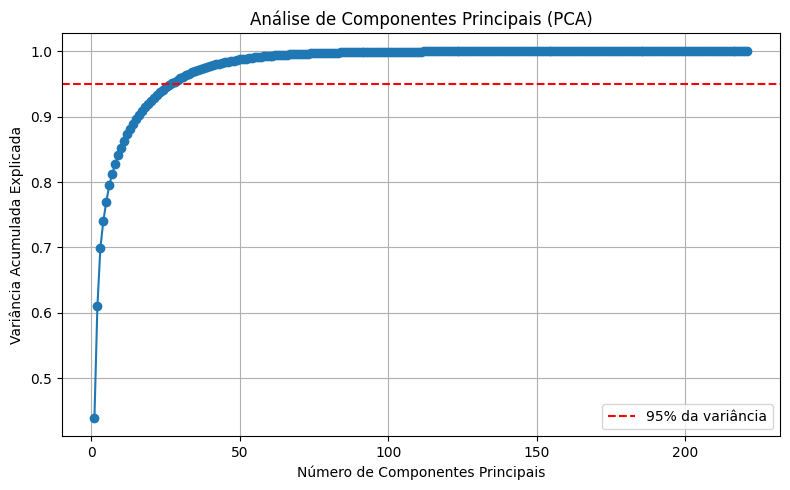


Número de componentes que explicam 95% da variância: 27
Dimensão original: 221, dimensão após PCA: 27


In [110]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=None, random_state=42)
pca.fit(X_train_scaled)

# Variância explicada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Gráfico da variância explicada
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Acumulada Explicada")
plt.title("Análise de Componentes Principais (PCA)")
plt.grid(True)
plt.axhline(0.95, color="red", linestyle="--", label="95% da variância")
plt.legend()
plt.tight_layout()
plt.show()

# Determinar quantos componentes mantêm 95% da variância
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"\nNúmero de componentes que explicam 95% da variância: {n_components_95}")

# Aplicar PCA com o número ótimo de componentes
pca_final = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca  = pca_final.transform(X_test_scaled)

print(f"Dimensão original: {X_train.shape[1]}, dimensão após PCA: {X_train_pca.shape[1]}")

In [111]:
# Converter o resultado do PCA em DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(n_components_95)])
X_test_pca_df  = pd.DataFrame(X_test_pca,  columns=[f"PC{i+1}" for i in range(n_components_95)])

# Visualizar as primeiras linhas
print("Head das novas features após PCA:")
display(X_train_pca_df.head())

Head das novas features após PCA:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,-6.979387,-5.911434,0.047749,1.968567,1.453961,0.310127,-0.387347,0.297951,1.216611,-0.786061,-0.641117,-1.603324,0.294948,-1.217696,1.517013,0.329660,-1.149492,-0.308714,-0.814757,0.221284,0.438449,0.151829,-0.000152,-0.342389,-0.242330,-0.188789,-0.281395
1,-5.905736,-3.428655,-0.600298,-0.003731,-1.271987,-0.166192,-0.185238,0.622862,1.670068,0.380857,-1.193446,-0.620739,2.008824,1.063225,-1.188690,-1.025196,-0.004766,2.147363,-1.385419,-0.822633,-0.781696,0.509190,-0.797713,0.310003,-1.263666,-0.510772,-1.010054
2,6.724722,-2.875351,-0.289746,-2.668378,0.032010,-1.915116,-1.935846,2.818973,-0.936399,0.568680,-1.029540,0.185406,3.899258,-1.993518,-1.799403,-0.398945,-0.196801,-1.310178,2.409607,0.089990,0.767349,-0.269937,1.296951,0.509465,-0.272939,-1.149190,-0.306240
3,-7.418089,-4.629968,1.455928,2.099278,0.268231,-0.834543,0.838820,-0.628821,-0.942162,-0.014574,-1.719781,-0.456304,-0.014359,-0.893467,0.583023,-0.602703,-0.000019,-0.673866,-0.697111,0.080282,0.406169,-0.336675,-0.430817,-0.534081,-0.068335,-0.550194,-0.096028
4,12.898412,-0.418333,-1.420864,-1.536209,0.272410,-1.400411,1.257923,-1.850389,-1.160334,-2.702514,-1.474955,1.743192,0.524950,-2.035874,-0.331309,0.077643,-0.465032,-0.234715,-0.197942,-0.143818,-0.218715,0.762516,0.206544,-0.020602,-0.485760,0.351180,-0.155577


A aplicação da Análise de Componentes Principais (PCA) reduziu significativamente a dimensionalidade do conjunto de dados radiômicos, passando de 221 features originais para apenas 27 componentes principais, que explicam 95% da variância total.
Isso demonstra que grande parte da informação contida nas features originais está concentrada em um pequeno subconjunto de combinações lineares, evidenciando alta redundância entre as variáveis radiômicas.
Assim, o PCA permite uma representação mais compacta e eficiente dos dados, reduzindo ruído e correlações redundantes, embora à custa de menor interpretabilidade clínica, já que os componentes principais são combinações matemáticas das features originais.

Dado que o dataset contém simultaneamente features radiômicas contínuas e variáveis clínicas ordinais (convertidas em escala 1–5/6), é possível aplicar o PCA tradicional, desde que todos os atributos sejam previamente normalizados.
As variáveis ordinais apresentam uma progressão monotónica coerente, o que justifica o seu tratamento como variáveis numéricas contínuas para efeito de decomposição linear.